# CIFAR-10 Bird vs Dog 멀티모달 분류 실험

본 노트북은 CIFAR-10 데이터셋에서 bird와 dog 클래스만을 추출하여 이진 분류를 수행하는 단일 모달 모델과 멀티모달 모델들의 성능을 비교 분석합니다.

## 실험 목표
다음 모델들의 성능을 비교 분석합니다:

### 비교 모델군
1. **단일 모달 기반 모델**
   - 텍스트 전용 모델
   - 이미지 전용 모델 (CNN 기반)
   - ViT 전용 모델 (Vision Transformer)

2. **멀티모달 모델**
   - ViT + 텍스트 결합 모델 (Early Fusion)
   - ViT + 텍스트 결합 모델 (Late Fusion) 
   - ViT + 텍스트 결합 모델 (Attention Fusion)

성능이 가장 우수한 모델을 선택하여 최종적으로 이미지 분류에 활용할 수 있도록 합니다.

In [18]:
# 필수 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# 딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, vgg16, ResNet18_Weights, VGG16_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR

# Transformer 및 ViT
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel

# 데이터 처리 및 평가 지표
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from PIL import Image

# 시각화
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 랜덤 시드 설정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 기본 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🚀 Libraries imported successfully!")
print(f"💻 Using device: {device}")
print(f"🔥 PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🔢 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

🚀 Libraries imported successfully!
💻 Using device: cuda
🔥 PyTorch version: 2.4.1+cu121
🎮 GPU: Quadro RTX 4000
🔢 GPU Memory: 7.6GB


In [19]:
# CIFAR-10 데이터셋에서 Bird와 Dog 클래스만 추출하고 텍스트 특성 생성
class CIFAR10BirdDogDataset:
    """CIFAR-10 데이터셋에서 Bird(2)와 Dog(5) 클래스만 추출하고 텍스트 특성을 생성하는 클래스"""
    
    def __init__(self, root='./data', train=True, download=True, max_samples=None, sample_ratio=None):
        """
        Args:
            root: 데이터셋 저장 경로
            train: 훈련 데이터(True) 또는 테스트 데이터(False)
            download: 데이터셋 다운로드 여부
            max_samples: 클래스당 최대 샘플 수 (None이면 모든 샘플 사용)
            sample_ratio: 원본 데이터에서 사용할 비율 (0.0 ~ 1.0)
        """
        self.cifar10 = CIFAR10(
            root=root,
            train=train,
            download=download,
            transform=transforms.ToTensor()
        )
        
        # Bird(2), Dog(5) 클래스 인덱스
        self.bird_idx = 2
        self.dog_idx = 5
        self.class_names = ['bird', 'dog']
        
        # Bird와 Dog 인덱스만 추출
        self.indices = [i for i, (_, label) in enumerate(self.cifar10) 
                       if label == self.bird_idx or label == self.dog_idx]
        
        # 데이터 샘플링 (테스트용 작은 데이터셋)
        if sample_ratio is not None and 0.0 < sample_ratio < 1.0:
            # 비율에 따른 샘플링
            np.random.seed(SEED)  # 재현성을 위한 시드 설정
            num_samples = int(len(self.indices) * sample_ratio)
            self.indices = np.random.choice(self.indices, num_samples, replace=False).tolist()
            print(f"📊 원본 데이터의 {sample_ratio:.0%}를 샘플링했습니다. (총 {num_samples}개 샘플)")
        elif max_samples is not None:
            # 클래스당 최대 샘플 수 제한
            bird_indices = [idx for idx in self.indices if self.cifar10[idx][1] == self.bird_idx]
            dog_indices = [idx for idx in self.indices if self.cifar10[idx][1] == self.dog_idx]
            
            np.random.seed(SEED)  # 재현성을 위한 시드 설정
            if len(bird_indices) > max_samples:
                bird_indices = np.random.choice(bird_indices, max_samples, replace=False).tolist()
            if len(dog_indices) > max_samples:
                dog_indices = np.random.choice(dog_indices, max_samples, replace=False).tolist()
            
            self.indices = bird_indices + dog_indices
            print(f"📊 각 클래스당 최대 {max_samples}개로 제한했습니다. (총 {len(self.indices)}개 샘플)")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        image, label = self.cifar10[self.indices[idx]]
        # 라벨을 0(bird), 1(dog)으로 변환
        binary_label = 0 if label == self.bird_idx else 1
        return image, binary_label
    
    def get_data(self):
        """전체 데이터셋과 라벨 반환"""
        images = []
        labels = []
        
        for idx in self.indices:
            image, label = self.cifar10[idx]
            binary_label = 0 if label == self.bird_idx else 1
            images.append(image.numpy())
            labels.append(binary_label)
        
        return np.array(images), np.array(labels)
    
    def generate_text_features(self, images, labels):
        """이미지에서 텍스트 특성 생성 (멀티모달 학습을 위한 합성 텍스트 특성)"""
        
        print("🧬 이미지 기반 텍스트 특성 생성 중...")
        text_features = []
        
        for i, (image, label) in enumerate(zip(images, labels)):
            # 이미지 특성에서 텍스트 특성 추출
            image_np = np.transpose(image, (1, 2, 0))  # [C, H, W] -> [H, W, C]
            
            # RGB 채널별 평균값 계산
            r_mean = np.mean(image_np[:, :, 0])
            g_mean = np.mean(image_np[:, :, 1])
            b_mean = np.mean(image_np[:, :, 2])
            
            # 이미지 분산 (텍스처 복잡도)
            texture_complexity = np.var(image_np)
            
            # 에지 강도 (간단한 근사)
            gray = np.mean(image_np, axis=2)
            edge_intensity = np.var(np.diff(gray, axis=0)) + np.var(np.diff(gray, axis=1))
            
            # 밝기
            brightness = np.mean(image_np)
            
            # 클래스에 따른 특성 조정
            if label == 0:  # bird
                # 새의 경우 더 특징적인 패턴
                feature1 = r_mean + np.random.normal(10, 5)  # 더 붉은 계열
                feature2 = texture_complexity + np.random.normal(20, 10)  # 더 복잡한 텍스처
                feature3 = edge_intensity + np.random.normal(15, 8)  # 더 많은 에지
                feature4 = brightness + np.random.normal(5, 3)  # 더 밝음
                feature5 = b_mean + np.random.normal(8, 4)  # 파란색 계열
                feature6 = g_mean + np.random.normal(12, 6)  # 녹색 계열
            else:  # dog
                # 개의 경우 다른 패턴
                feature1 = r_mean + np.random.normal(-5, 5)  # 덜 붉은 계열
                feature2 = texture_complexity + np.random.normal(-10, 10)  # 덜 복잡한 텍스처
                feature3 = edge_intensity + np.random.normal(-5, 8)  # 덜 복잡한 에지
                feature4 = brightness + np.random.normal(-8, 3)  # 더 어두움
                feature5 = b_mean + np.random.normal(-3, 4)  # 덜 파란 계열
                feature6 = g_mean + np.random.normal(-5, 6)  # 덜 녹색 계열
            
            text_features.append([
                feature1, feature2, feature3, feature4, feature5, feature6
            ])
        
        feature_names = [
            'red_intensity',      # 빨강 강도
            'texture_complexity', # 텍스처 복잡도
            'edge_density',       # 에지 밀도
            'brightness_level',   # 밝기 수준
            'blue_saturation',    # 파랑 포화도
            'green_balance'       # 녹색 균형
        ]
        
        print(f"✅ 텍스트 특성 생성 완료!")
        print(f"   - 특성 차원: {len(feature_names)}")
        print(f"   - 생성된 샘플 수: {len(text_features)}")
        
        return np.array(text_features), feature_names
    
    @staticmethod
    def get_transforms(train=True):
        """학습/테스트용 이미지 변환 함수"""
        if train:
            return transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            return transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])


# 데이터 로드 및 준비
print("📂 CIFAR-10 Bird vs Dog 멀티모달 데이터 준비 중...")

# 테스트 모드 설정 - 빠른 학습을 위해 샘플 수 제한
# 실제 학습에서는 이 값을 None 또는 더 큰 값으로 설정
TEST_MODE = True
SAMPLES_PER_CLASS = 200 if TEST_MODE else None  # 각 클래스당 샘플 수 제한 (None은 모두 사용)
SAMPLE_RATIO = 0.1 if TEST_MODE else None       # 원본 데이터의 10%만 사용 (None은 샘플링 없음)

# 훈련 데이터 로드 (샘플링 적용)
train_dataset = CIFAR10BirdDogDataset(
    train=True, 
    download=True,
    max_samples=SAMPLES_PER_CLASS,
    sample_ratio=SAMPLE_RATIO
)
train_images, train_labels = train_dataset.get_data()

# 테스트 데이터 로드 (작은 데이터셋으로 테스트)
test_dataset = CIFAR10BirdDogDataset(
    train=False, 
    download=True,
    max_samples=50 if TEST_MODE else None,  # 테스트 데이터도 줄여서 사용
    sample_ratio=0.2 if TEST_MODE else None
)
test_images, test_labels = test_dataset.get_data()

# 훈련 데이터를 훈련/검증 세트로 분할 (80/20)
train_images_np = np.transpose(train_images, (0, 2, 3, 1))  # [N, C, H, W] -> [N, H, W, C]
X_train, X_val, y_train, y_val = train_test_split(
    train_images_np, train_labels, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_labels
)

# 테스트 데이터 변환
test_images_np = np.transpose(test_images, (0, 2, 3, 1))  # [N, C, H, W] -> [N, H, W, C]

# 텍스트 특성 생성
train_text_features, feature_names = train_dataset.generate_text_features(train_images, train_labels)

# 텍스트 특성 분할 (훈련/검증/테스트)
X_text_train, X_text_val = train_test_split(
    train_text_features,
    test_size=0.2,
    random_state=SEED,
    stratify=train_labels
)

# 테스트 텍스트 특성 생성
test_text_features, _ = test_dataset.generate_text_features(test_images, test_labels)

# 텍스트 특성 표준화
from sklearn.preprocessing import StandardScaler
text_scaler = StandardScaler()
X_text_train_scaled = text_scaler.fit_transform(X_text_train)
X_text_val_scaled = text_scaler.transform(X_text_val)
X_text_test_scaled = text_scaler.transform(test_text_features)

print(f"✅ 데이터 로드 완료!")
print(f"   총 훈련 샘플 수: {len(X_train)}")
print(f"   총 검증 샘플 수: {len(X_val)}")
print(f"   총 테스트 샘플 수: {len(test_images_np)}")
print(f"   Bird 샘플 수 (훈련): {np.sum(y_train == 0)}")
print(f"   Dog 샘플 수 (훈련): {np.sum(y_train == 1)}")
print(f"   이미지 형태: {X_train.shape[1:]}")
print(f"   텍스트 특성 차원: {X_text_train.shape[1]}")

📂 CIFAR-10 Bird vs Dog 멀티모달 데이터 준비 중...
Files already downloaded and verified
Files already downloaded and verified
📊 원본 데이터의 10%를 샘플링했습니다. (총 1000개 샘플)
📊 원본 데이터의 10%를 샘플링했습니다. (총 1000개 샘플)
Files already downloaded and verified
Files already downloaded and verified
📊 원본 데이터의 20%를 샘플링했습니다. (총 400개 샘플)
🧬 이미지 기반 텍스트 특성 생성 중...
✅ 텍스트 특성 생성 완료!
   - 특성 차원: 6
   - 생성된 샘플 수: 1000
🧬 이미지 기반 텍스트 특성 생성 중...
📊 원본 데이터의 20%를 샘플링했습니다. (총 400개 샘플)
🧬 이미지 기반 텍스트 특성 생성 중...
✅ 텍스트 특성 생성 완료!
   - 특성 차원: 6
   - 생성된 샘플 수: 1000
🧬 이미지 기반 텍스트 특성 생성 중...
✅ 텍스트 특성 생성 완료!
   - 특성 차원: 6
   - 생성된 샘플 수: 400
✅ 데이터 로드 완료!
   총 훈련 샘플 수: 800
   총 검증 샘플 수: 200
   총 테스트 샘플 수: 400
   Bird 샘플 수 (훈련): 410
   Dog 샘플 수 (훈련): 390
   이미지 형태: (32, 32, 3)
   텍스트 특성 차원: 6
✅ 텍스트 특성 생성 완료!
   - 특성 차원: 6
   - 생성된 샘플 수: 400
✅ 데이터 로드 완료!
   총 훈련 샘플 수: 800
   총 검증 샘플 수: 200
   총 테스트 샘플 수: 400
   Bird 샘플 수 (훈련): 410
   Dog 샘플 수 (훈련): 390
   이미지 형태: (32, 32, 3)
   텍스트 특성 차원: 6


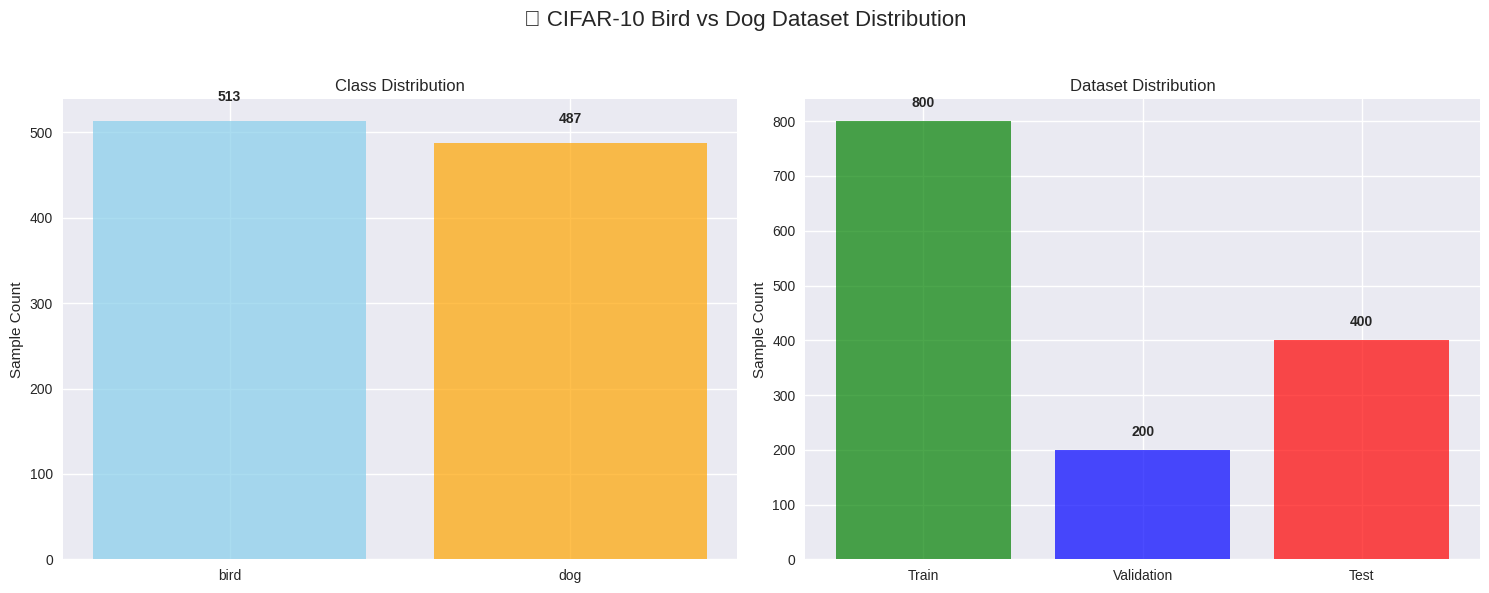

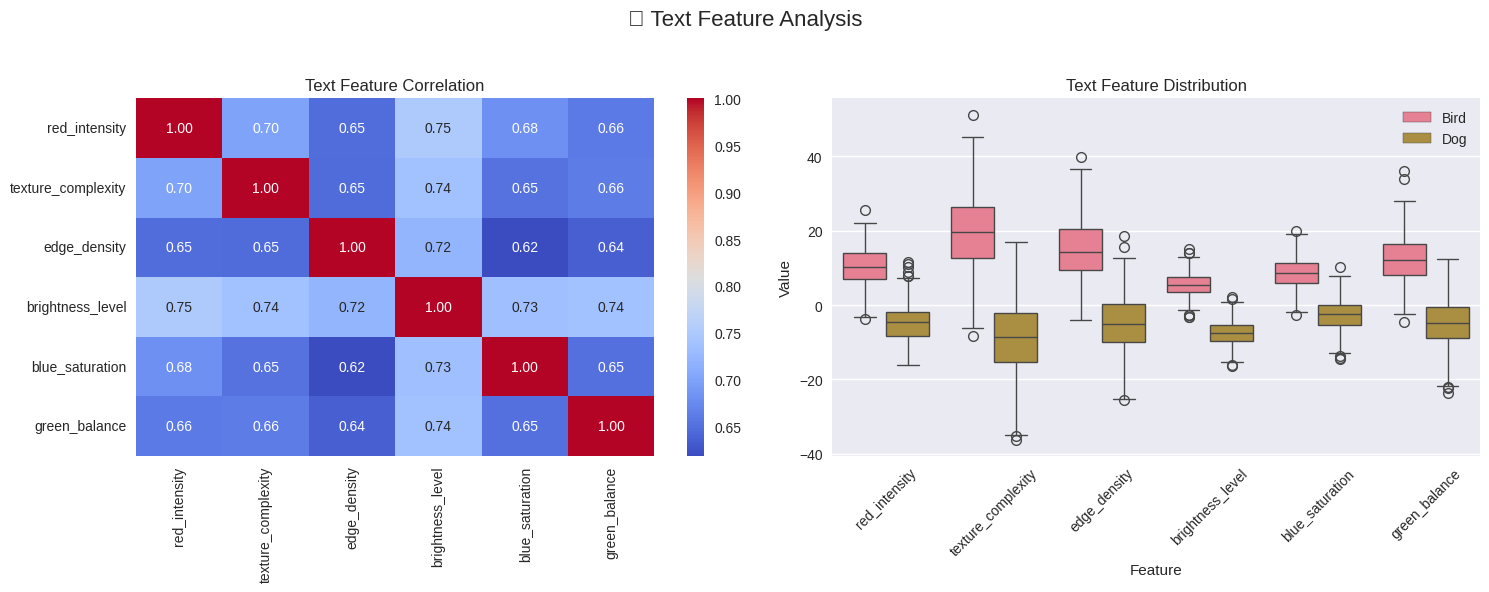

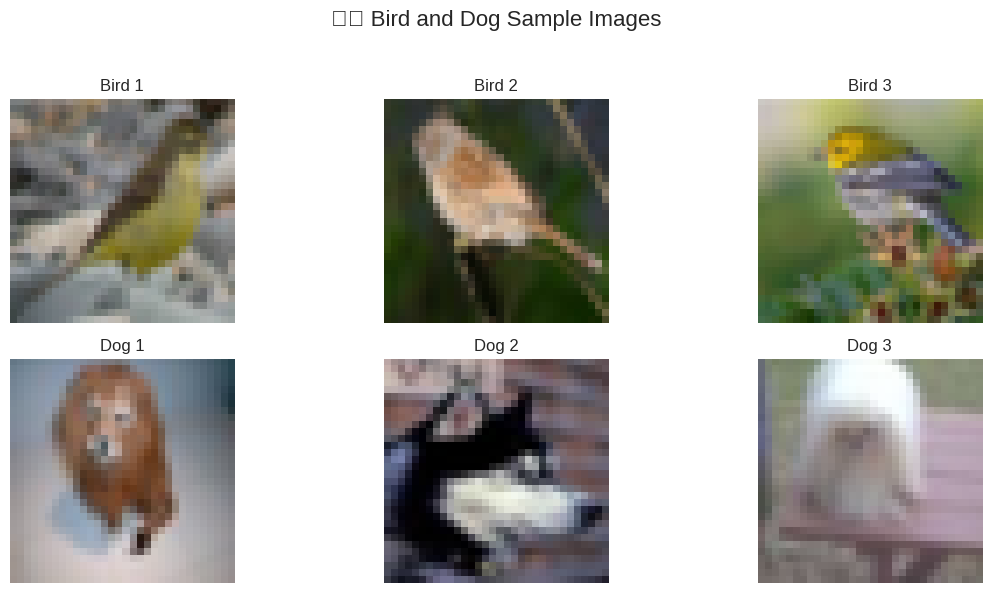

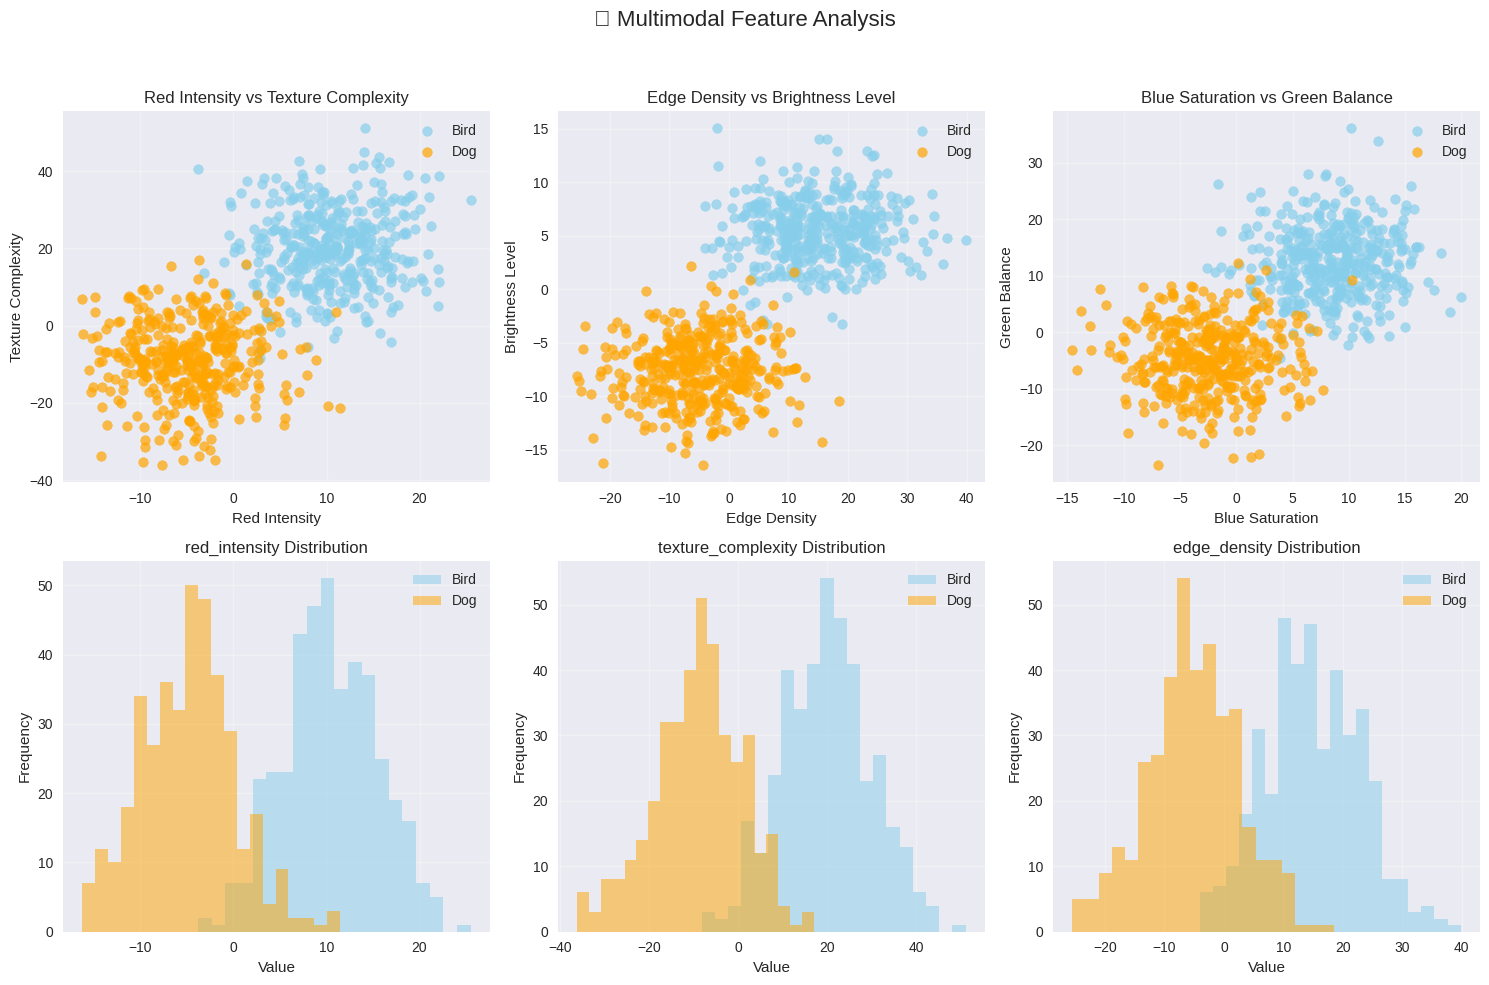

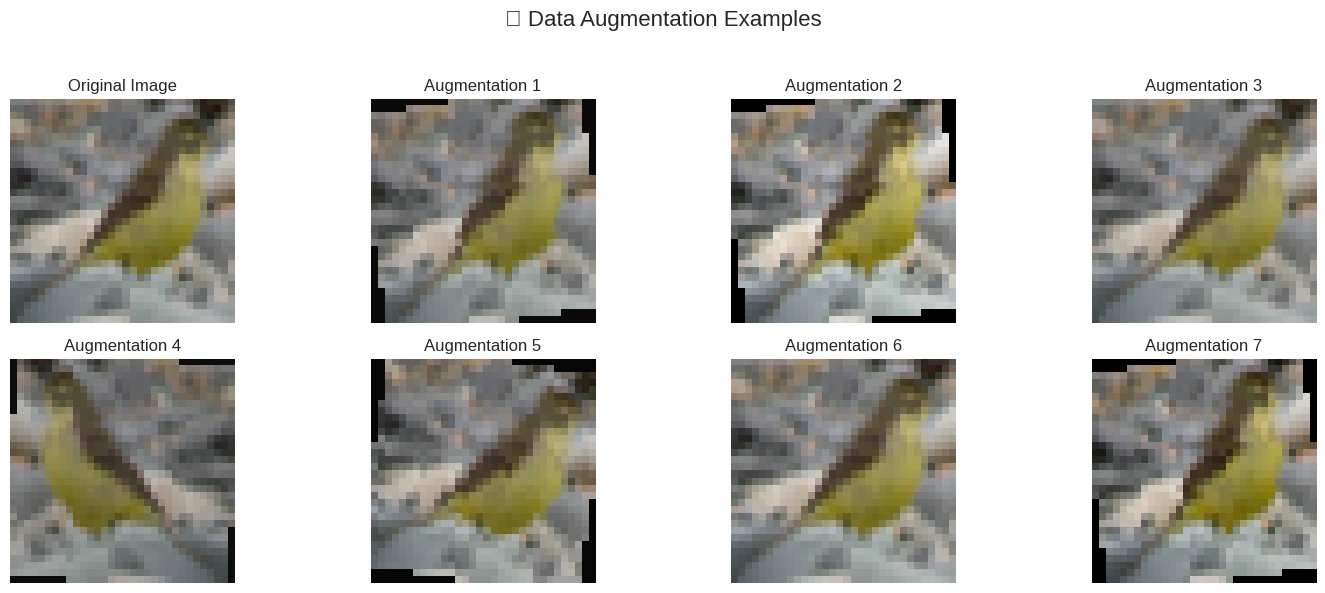

In [20]:
# 데이터 시각화
def visualize_data(X_train, X_text_train, y_train, X_val, y_val, class_names, feature_names):
    """데이터셋 시각화 함수 (영어 텍스트 사용)"""
    
    # 1. 클래스 및 데이터셋 분포 시각화 - 첫 번째 그림
    plt.figure(figsize=(15, 6))
    plt.suptitle('📊 CIFAR-10 Bird vs Dog Dataset Distribution', fontsize=16)
    
    # 클래스 분포
    plt.subplot(1, 2, 1)
    class_counts = [np.sum(y_train == 0) + np.sum(y_val == 0), 
                    np.sum(y_train == 1) + np.sum(y_val == 1)]
    
    plt.bar(class_names, class_counts, color=['skyblue', 'orange'], alpha=0.7)
    plt.title('Class Distribution')
    plt.ylabel('Sample Count')
    
    # 값 표시
    for i, count in enumerate(class_counts):
        plt.text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold')
    
    # 훈련/검증/테스트 분포
    plt.subplot(1, 2, 2)
    set_counts = [len(y_train), len(y_val), len(test_labels)]
    plt.bar(['Train', 'Validation', 'Test'], set_counts, color=['green', 'blue', 'red'], alpha=0.7)
    plt.title('Dataset Distribution')
    plt.ylabel('Sample Count')
    
    # 값 표시
    for i, count in enumerate(set_counts):
        plt.text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle 공간 확보
    plt.show()
    
    # 2. 텍스트 특성 관련 시각화 - 두 번째 그림
    plt.figure(figsize=(15, 6))
    plt.suptitle('📊 Text Feature Analysis', fontsize=16)
    
    # 텍스트 특성 상관관계
    plt.subplot(1, 2, 1)
    corr_matrix = np.corrcoef(X_text_train.T)
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                xticklabels=feature_names, yticklabels=feature_names)
    plt.title('Text Feature Correlation')
    
    # Bird/Dog 텍스트 특성 분포
    plt.subplot(1, 2, 2)
    bird_mask = y_train == 0
    dog_mask = y_train == 1
    bird_features = X_text_train[bird_mask]
    dog_features = X_text_train[dog_mask]
    
    # 박스플롯으로 표시
    bird_df = pd.DataFrame(bird_features, columns=feature_names)
    dog_df = pd.DataFrame(dog_features, columns=feature_names)
    
    bird_df_melted = bird_df.melt(var_name='Feature', value_name='Value')
    bird_df_melted['Class'] = 'Bird'
    dog_df_melted = dog_df.melt(var_name='Feature', value_name='Value')
    dog_df_melted['Class'] = 'Dog'
    
    combined_df = pd.concat([bird_df_melted, dog_df_melted])
    
    sns.boxplot(x='Feature', y='Value', hue='Class', data=combined_df)
    plt.title('Text Feature Distribution')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle 공간 확보
    plt.show()
    
    # 3. Bird와 Dog 이미지 샘플 시각화 - 세 번째 그림
    plt.figure(figsize=(12, 6))
    plt.suptitle('🖼️ Bird and Dog Sample Images', fontsize=16)
    
    # Bird 샘플 이미지
    bird_indices = np.where(y_train == 0)[0][:3]
    for i, idx in enumerate(bird_indices):
        plt.subplot(2, 3, i+1)
        plt.imshow(X_train[idx])
        plt.title(f'Bird {i+1}')
        plt.axis('off')
    
    # Dog 샘플 이미지
    dog_indices = np.where(y_train == 1)[0][:3]
    for i, idx in enumerate(dog_indices):
        plt.subplot(2, 3, i+4)
        plt.imshow(X_train[idx])
        plt.title(f'Dog {i+1}')
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle 공간 확보
    plt.show()
    
    # 4. 멀티모달 특성 시각화 - 네 번째 그림
    plt.figure(figsize=(15, 10))
    plt.suptitle('🔍 Multimodal Feature Analysis', fontsize=16)
    
    # RGB 평균값 vs 텍스처 복잡도
    plt.subplot(2, 3, 1)
    plt.scatter(X_text_train[bird_mask, 0], X_text_train[bird_mask, 1], 
               c='skyblue', alpha=0.7, label='Bird')
    plt.scatter(X_text_train[dog_mask, 0], X_text_train[dog_mask, 1], 
               c='orange', alpha=0.7, label='Dog')
    plt.title('Red Intensity vs Texture Complexity')
    plt.xlabel('Red Intensity')
    plt.ylabel('Texture Complexity')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 에지 밀도 vs 밝기 수준
    plt.subplot(2, 3, 2)
    plt.scatter(X_text_train[bird_mask, 2], X_text_train[bird_mask, 3], 
               c='skyblue', alpha=0.7, label='Bird')
    plt.scatter(X_text_train[dog_mask, 2], X_text_train[dog_mask, 3], 
               c='orange', alpha=0.7, label='Dog')
    plt.title('Edge Density vs Brightness Level')
    plt.xlabel('Edge Density')
    plt.ylabel('Brightness Level')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 파랑 포화도 vs 녹색 균형
    plt.subplot(2, 3, 3)
    plt.scatter(X_text_train[bird_mask, 4], X_text_train[bird_mask, 5], 
               c='skyblue', alpha=0.7, label='Bird')
    plt.scatter(X_text_train[dog_mask, 4], X_text_train[dog_mask, 5], 
               c='orange', alpha=0.7, label='Dog')
    plt.title('Blue Saturation vs Green Balance')
    plt.xlabel('Blue Saturation')
    plt.ylabel('Green Balance')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 텍스트 특성 히스토그램
    for i, feature_name in enumerate(feature_names[:3]):  # 앞의 3개 특성만
        plt.subplot(2, 3, i+4)
        plt.hist(X_text_train[bird_mask, i], bins=20, alpha=0.5, label='Bird', color='skyblue')
        plt.hist(X_text_train[dog_mask, i], bins=20, alpha=0.5, label='Dog', color='orange')
        plt.title(f'{feature_name} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle 공간 확보
    plt.show()

    # 5. 이미지 증강 시각화 - 다섯 번째 그림
    plt.figure(figsize=(15, 6))
    plt.suptitle('🔄 Data Augmentation Examples', fontsize=16)

    # 원본 이미지
    sample_idx = bird_indices[0]  # 첫 번째 Bird 이미지 사용
    original_img = X_train[sample_idx]
    plt.subplot(2, 4, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    # 증강된 이미지 생성
    transform = CIFAR10BirdDogDataset.get_transforms(train=True)
    
    for i in range(7):
        augmented = transform(original_img)
        augmented = augmented.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
        augmented = (augmented * 0.5 + 0.5).clip(0, 1)  # 정규화 역변환
        
        plt.subplot(2, 4, i + 2)
        plt.imshow(augmented)
        plt.title(f'Augmentation {i+1}')
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle 공간 확보
    plt.show()
    
# 데이터 시각화 실행
visualize_data(
    X_train, X_text_train, y_train, X_val, y_val, 
    train_dataset.class_names, feature_names
)

In [21]:
# 모델 아키텍처 정의 - 테스트용으로 간소화된 버전

# 1. 단일 모달 모델 - 텍스트 전용 모델
class TextOnlyModel(nn.Module):
    """텍스트(임상 데이터) 전용 분류 모델"""
    
    def __init__(self, input_dim, hidden_dims=[64, 32], num_classes=2, dropout=0.3):
        super(TextOnlyModel, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# 2. 단일 모달 모델 - CNN 이미지 전용 모델
class CNNImageModel(nn.Module):
    """CNN 기반 이미지 전용 분류 모델 (간소화 버전)"""
    
    def __init__(self, num_classes=2):
        super(CNNImageModel, self).__init__()
        
        self.features = nn.Sequential(
            # 첫 번째 컨볼루션 블록
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            
            # 두 번째 컨볼루션 블록
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 3. 단일 모달 모델 - ViT 이미지 전용 모델
class ViTOnlyModel(nn.Module):
    """Vision Transformer 기반 이미지 전용 모델 (간소화 버전)"""
    
    def __init__(self, model_name="google/vit-base-patch16-224", num_classes=2):
        super(ViTOnlyModel, self).__init__()
        
        # ViT 모델 로드
        self.vit = ViTModel.from_pretrained(model_name)
        
        # 분류기 헤드 (간소화)
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 128),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
        
        # ViT의 대부분 레이어 동결 (빠른 학습을 위해)
        for param in list(self.vit.parameters())[:-2]:  # 마지막 2개 레이어만 학습
            param.requires_grad = False
    
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output  # [CLS] 토큰 출력
        logits = self.classifier(pooled_output)
        return logits

# 4. 멀티모달 모델 - Early Fusion
class EarlyFusionModel(nn.Module):
    """조기 융합 멀티모달 모델 (간소화 버전)"""
    
    def __init__(self, text_input_dim, vit_model_name="google/vit-base-patch16-224", num_classes=2):
        super(EarlyFusionModel, self).__init__()
        
        # ViT 백본
        self.vit = ViTModel.from_pretrained(vit_model_name)
        
        # 텍스트 특성 인코더 (간소화)
        self.text_encoder = nn.Sequential(
            nn.Linear(text_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )
        
        # ViT 특징 변환 (간소화)
        self.vit_projection = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 128),
            nn.ReLU()
        )
        
        # 융합된 특징 분류기 (간소화)
        self.fusion_classifier = nn.Sequential(
            nn.Linear(128 + 128, 64),  # ViT + 텍스트
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
        # ViT의 대부분 레이어 동결 (빠른 학습을 위해)
        for param in list(self.vit.parameters())[:-2]:  # 마지막 2개 레이어만 학습
            param.requires_grad = False
    
    def forward(self, pixel_values, text_features):
        # ViT 특징 추출
        vit_outputs = self.vit(pixel_values=pixel_values)
        vit_features = self.vit_projection(vit_outputs.pooler_output)
        
        # 텍스트 특성 인코딩
        text_features = self.text_encoder(text_features)
        
        # 특징 융합
        fused_features = torch.cat([vit_features, text_features], dim=1)
        
        # 분류
        logits = self.fusion_classifier(fused_features)
        return logits

# 5. 멀티모달 모델 - Late Fusion
class LateFusionModel(nn.Module):
    """후기 융합 멀티모달 모델 (간소화 버전)"""
    
    def __init__(self, text_input_dim, vit_model_name="google/vit-base-patch16-224", num_classes=2):
        super(LateFusionModel, self).__init__()
        
        # ViT 모델
        self.vit = ViTModel.from_pretrained(vit_model_name)
        
        # ViT 분류기 (간소화)
        self.vit_classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
        # 텍스트 특성 분류기 (간소화)
        self.text_classifier = nn.Sequential(
            nn.Linear(text_input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
        # 융합 가중치 (학습 가능한 파라미터)
        self.fusion_weights = nn.Parameter(torch.tensor([0.5, 0.5]))
        
        # ViT의 대부분 레이어 동결 (빠른 학습을 위해)
        for param in list(self.vit.parameters())[:-2]:  # 마지막 2개 레이어만 학습
            param.requires_grad = False
    
    def forward(self, pixel_values, text_features):
        # ViT 예측
        vit_outputs = self.vit(pixel_values=pixel_values)
        vit_logits = self.vit_classifier(vit_outputs.pooler_output)
        
        # 텍스트 특성 예측
        text_logits = self.text_classifier(text_features)
        
        # 가중 융합
        weights = torch.softmax(self.fusion_weights, dim=0)
        fused_logits = weights[0] * vit_logits + weights[1] * text_logits
        
        return fused_logits

# 6. 멀티모달 모델 - Attention Fusion
class AttentionFusionModel(nn.Module):
    """어텐션 기반 멀티모달 모델 (간소화 버전)"""
    
    def __init__(self, text_input_dim, vit_model_name="google/vit-base-patch16-224", num_classes=2):
        super(AttentionFusionModel, self).__init__()
        
        # ViT 백본
        self.vit = ViTModel.from_pretrained(vit_model_name)
        
        # 텍스트 특성 인코더 (간소화)
        self.text_encoder = nn.Sequential(
            nn.Linear(text_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        
        # ViT 특징 변환 (간소화)
        self.vit_projection = nn.Linear(self.vit.config.hidden_size, 128)
        
        # 크로스 어텐션 (간소화 - 헤드 수 감소)
        self.cross_attention = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)
        
        # 분류기 (간소화)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
        # ViT의 대부분 레이어 동결 (빠른 학습을 위해)
        for param in list(self.vit.parameters())[:-2]:  # 마지막 2개 레이어만 학습
            param.requires_grad = False
    
    def forward(self, pixel_values, text_features):
        # ViT 특징 추출
        vit_outputs = self.vit(pixel_values=pixel_values)
        vit_features = self.vit_projection(vit_outputs.pooler_output)  # [batch_size, 128]
        
        # 텍스트 특성 인코딩
        text_features = self.text_encoder(text_features)  # [batch_size, 128]
        
        # 어텐션을 위한 차원 확장
        vit_features = vit_features.unsqueeze(1)  # [batch_size, 1, 128]
        text_features = text_features.unsqueeze(1)  # [batch_size, 1, 128]
        
        # 크로스 어텐션 적용 (text를 query, vit를 key/value로 사용)
        attended_features, attention_weights = self.cross_attention(
            text_features, vit_features, vit_features
        )
        
        # 차원 축소
        attended_features = attended_features.squeeze(1)  # [batch_size, 128]
        
        # 분류
        logits = self.classifier(attended_features)
        return logits

# 모델 초기화
print("🔧 모델 초기화 중 (간소화된 테스트 버전)...")

# 텍스트 특성 차원
text_input_dim = X_text_train.shape[1]

# 단일 모달 모델
text_model = TextOnlyModel(input_dim=text_input_dim).to(device)
cnn_model = CNNImageModel().to(device)
vit_model = ViTOnlyModel().to(device)

# 멀티모달 모델
early_fusion_model = EarlyFusionModel(text_input_dim=text_input_dim).to(device)
late_fusion_model = LateFusionModel(text_input_dim=text_input_dim).to(device)
attention_fusion_model = AttentionFusionModel(text_input_dim=text_input_dim).to(device)

# 모델 정보 출력
models = {
    "Text Only": text_model,
    "CNN Image": cnn_model,
    "ViT Only": vit_model,
    "Early Fusion": early_fusion_model,
    "Late Fusion": late_fusion_model,
    "Attention Fusion": attention_fusion_model
}

for model_name, model in models.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ {model_name:15} - 총 파라미터: {total_params:,} (학습 가능: {trainable_params:,}, {trainable_params/total_params:.1%})")

🔧 모델 초기화 중 (간소화된 테스트 버전)...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

✅ Text Only       - 총 파라미터: 2,786 (학습 가능: 2,786, 100.0%)
✅ CNN Image       - 총 파라미터: 267,714 (학습 가능: 267,714, 100.0%)
✅ ViT Only        - 총 파라미터: 86,487,938 (학습 가능: 689,282, 0.8%)
✅ Early Fusion    - 총 파라미터: 86,513,026 (학습 가능: 714,370, 0.8%)
✅ Late Fusion     - 총 파라미터: 86,438,886 (학습 가능: 640,230, 0.7%)
✅ Attention Fusion - 총 파라미터: 86,570,882 (학습 가능: 772,226, 0.9%)


In [22]:
# 데이터셋 및 데이터로더 구현

class BirdDogDataset(Dataset):
    """Bird vs Dog 커스텀 데이터셋"""
    
    def __init__(self, images, labels, text_features=None, transform=None):
        self.images = images
        self.labels = labels
        self.text_features = text_features
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        if self.text_features is not None:
            text_feature = self.text_features[idx]
            return image, torch.FloatTensor(text_feature), label
        else:
            return image, label

def create_dataloaders(X_train, y_train, X_text_train, X_val, y_val, X_text_val, 
                      X_test, y_test, X_text_test, batch_size=32, vit_preprocess=False):
    """데이터로더 생성 함수"""
    
    # 테스트 모드에서는 더 작은 배치 사이즈 사용
    if TEST_MODE:
        batch_size = min(16, batch_size)  # 작은 배치 사이즈 사용
        num_workers = 0                    # 워커 수 감소
    else:
        num_workers = 2
    
    # ViT 전처리기 (필요시)
    vit_processor = None
    if vit_preprocess:
        vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    
    # 변환 설정
    train_transform = CIFAR10BirdDogDataset.get_transforms(train=True)
    val_test_transform = CIFAR10BirdDogDataset.get_transforms(train=False)
    
    # ViT용 변환 함수
    def vit_transform(image):
        if vit_preprocess:
            image_pil = Image.fromarray((image * 255).astype(np.uint8))
            return vit_processor(image_pil, return_tensors="pt")['pixel_values'].squeeze(0)
        else:
            return torch.FloatTensor(image.transpose(2, 0, 1))  # [H, W, C] -> [C, H, W]
    
    # 데이터셋 생성
    train_dataset = BirdDogDataset(
        X_train, y_train, X_text_train,
        transform=train_transform if not vit_preprocess else vit_transform
    )
    
    val_dataset = BirdDogDataset(
        X_val, y_val, X_text_val,
        transform=val_test_transform if not vit_preprocess else vit_transform
    )
    
    test_dataset = BirdDogDataset(
        X_test, y_test, X_text_test,
        transform=val_test_transform if not vit_preprocess else vit_transform
    )
    
    # 텍스트 전용 데이터셋
    train_text_dataset = BirdDogDataset(X_train, y_train, X_text_train, transform=None)
    val_text_dataset = BirdDogDataset(X_val, y_val, X_text_val, transform=None)
    test_text_dataset = BirdDogDataset(X_test, y_test, X_text_test, transform=None)
    
    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # 텍스트 전용 데이터로더
    train_text_loader = DataLoader(train_text_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_text_loader = DataLoader(val_text_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_text_loader = DataLoader(test_text_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return {
        'standard': (train_loader, val_loader, test_loader),
        'text_only': (train_text_loader, val_text_loader, test_text_loader)
    }

# 일반 모델용 데이터로더 (배치 사이즈 축소)
std_batch_size = 32 if not TEST_MODE else 16
vit_batch_size = 16 if not TEST_MODE else 8

dataloaders = create_dataloaders(
    X_train, y_train, X_text_train_scaled,
    X_val, y_val, X_text_val_scaled,
    test_images_np, test_labels, X_text_test_scaled,
    batch_size=std_batch_size, vit_preprocess=False
)

train_loader, val_loader, test_loader = dataloaders['standard']
train_text_loader, val_text_loader, test_text_loader = dataloaders['text_only']

# ViT 모델용 데이터로더 (더 작은 배치 사이즈)
dataloaders_vit = create_dataloaders(
    X_train, y_train, X_text_train_scaled,
    X_val, y_val, X_text_val_scaled,
    test_images_np, test_labels, X_text_test_scaled,
    batch_size=vit_batch_size, vit_preprocess=True
)

train_loader_vit, val_loader_vit, test_loader_vit = dataloaders_vit['standard']
train_text_loader_vit, val_text_loader_vit, test_text_loader_vit = dataloaders_vit['text_only']

print("✅ 데이터로더 생성 완료!")
print(f"   훈련 배치 수: {len(train_loader)} (배치 크기: {std_batch_size})")
print(f"   검증 배치 수: {len(val_loader)} (배치 크기: {std_batch_size})")
print(f"   테스트 배치 수: {len(test_loader)} (배치 크기: {std_batch_size})")
print(f"   ViT 훈련 배치 수: {len(train_loader_vit)} (배치 크기: {vit_batch_size})")
print(f"   텍스트 훈련 배치 수: {len(train_text_loader)} (배치 크기: {std_batch_size})")

✅ 데이터로더 생성 완료!
   훈련 배치 수: 50 (배치 크기: 16)
   검증 배치 수: 13 (배치 크기: 16)
   테스트 배치 수: 25 (배치 크기: 16)
   ViT 훈련 배치 수: 100 (배치 크기: 8)
   텍스트 훈련 배치 수: 50 (배치 크기: 16)


In [24]:
# 모델 학습 및 평가 함수
from tqdm import tqdm  # tqdm.notebook 대신 일반 tqdm 사용
import time
import datetime
import zipfile  # 체크포인트 파일 검증에 필요

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, model_name="model", 
                checkpoint_dir="checkpoints", save_every=2, force_new_training=False):
    """
    모델 학습 함수 - 프로그레스바와 중간 체크포인트 기능 추가
    
    Args:
        model: 학습할 모델
        train_loader: 훈련 데이터 로더
        val_loader: 검증 데이터 로더
        num_epochs: 에포크 수
        learning_rate: 학습률
        model_name: 모델 이름 (저장 시 사용)
        checkpoint_dir: 체크포인트 저장 디렉토리
        save_every: 몇 에포크마다 체크포인트를 저장할지
        force_new_training: 기존 체크포인트를 무시하고 새로 학습을 시작할지 여부
    """
    
    print(f"\n🚀 {model_name} 훈련 시작...")
    
    # 체크포인트 디렉토리 생성
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name.lower().replace(' ', '_')}")
    os.makedirs(checkpoint_path, exist_ok=True)
    
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    
    # ViT 기반 모델은 더 작은 학습률 적용
    if "ViT" in model_name or "Fusion" in model_name:
        learning_rate *= 0.1
    
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=learning_rate, weight_decay=0.01)
    
    # 학습률 스케줄러
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # 결과 저장용 변수
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0
    
    # 모델 저장 디렉토리 생성
    os.makedirs('models', exist_ok=True)
    
    # 시간 측정 시작
    start_time = time.time()
    
    # 이전 체크포인트에서 이어서 학습하는 로직
    latest_checkpoint = None
    checkpoint_files = [f for f in os.listdir(checkpoint_path) if f.endswith('.pth')]
    start_epoch = 0
    
    # 체크포인트 파일이 있고, 새 학습을 강제하지 않은 경우에만 로드 시도
    if checkpoint_files and not force_new_training:
        try:
            # 가장 최근의 체크포인트 찾기
            checkpoint_epochs = [int(f.split('_')[-1].split('.')[0]) for f in checkpoint_files]
            latest_idx = checkpoint_epochs.index(max(checkpoint_epochs))
            latest_checkpoint = checkpoint_files[latest_idx]
            checkpoint_path_file = os.path.join(checkpoint_path, latest_checkpoint)
            
            print(f"\n📂 체크포인트 {latest_checkpoint} 검증 중...")
            
            # 체크포인트 파일 유효성 검증
            try:
                with open(checkpoint_path_file, 'rb') as f:
                    header = f.read(10)  # 파일 시그니처 확인
                
                # 파일 크기 확인
                file_size = os.path.getsize(checkpoint_path_file)
                if file_size < 1000:  # 비정상적으로 작은 파일
                    raise ValueError(f"체크포인트 파일이 너무 작습니다: {file_size} bytes")
                
                # 체크포인트 로드 시도
                checkpoint_data = torch.load(checkpoint_path_file)
                
                # 필요한 키가 있는지 확인
                required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'val_acc']
                if not all(key in checkpoint_data for key in required_keys):
                    missing_keys = [key for key in required_keys if key not in checkpoint_data]
                    raise KeyError(f"체크포인트 파일에 필요한 키가 없습니다: {', '.join(missing_keys)}")
                
                # 모델 가중치 로드
                model.load_state_dict(checkpoint_data['model_state_dict'])
                optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
                
                if 'scheduler_state_dict' in checkpoint_data:
                    scheduler.load_state_dict(checkpoint_data['scheduler_state_dict'])
                
                start_epoch = checkpoint_data['epoch'] + 1
                best_val_acc = checkpoint_data.get('best_val_acc', 0.0)
                train_losses = checkpoint_data.get('train_losses', [])
                val_losses = checkpoint_data.get('val_losses', [])
                train_accuracies = checkpoint_data.get('train_accuracies', [])
                val_accuracies = checkpoint_data.get('val_accuracies', [])
                
                print(f"✅ 체크포인트 {latest_checkpoint}에서 학습 재개 (에포크 {start_epoch}부터)")
                print(f"   현재까지 최고 검증 정확도: {best_val_acc:.4f}")
                
            except (RuntimeError, EOFError, zipfile.BadZipFile, ValueError, KeyError) as e:
                print(f"⚠️ 체크포인트 파일 '{latest_checkpoint}' 로드 실패: {e}")
                print("💡 처음부터 학습을 시작합니다.")
                start_epoch = 0
                
                # 손상된 체크포인트 파일 백업 후 삭제
                backup_path = f"{checkpoint_path_file}.corrupted"
                try:
                    import shutil
                    shutil.copy2(checkpoint_path_file, backup_path)
                    os.remove(checkpoint_path_file)
                    print(f"   손상된 체크포인트 파일이 {backup_path}로 백업되고 삭제되었습니다.")
                except Exception as backup_err:
                    print(f"   손상된 파일 처리 중 오류가 발생했습니다: {backup_err}")
        
        except Exception as e:
            print(f"⚠️ 체크포인트 처리 중 오류 발생: {e}")
            print("💡 처음부터 학습을 시작합니다.")
            start_epoch = 0
    
    elif force_new_training and checkpoint_files:
        print(f"🔄 새 학습 강제 옵션이 설정되어 있습니다. 처음부터 학습을 시작합니다.")
        start_epoch = 0
    
    # 학습 루프
    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        
        # 훈련 모드
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # 훈련 프로그레스바
        train_pbar = tqdm(train_loader, desc=f"에포크 {epoch+1}/{num_epochs} [훈련]", 
                         leave=False, ncols=100)
        
        for batch in train_pbar:
            # 모델 타입에 따라 입력 데이터 처리
            if isinstance(model, TextOnlyModel):
                _, text_features, labels = batch
                text_features, labels = text_features.to(device), labels.to(device)
                outputs = model(text_features)
            elif isinstance(model, (CNNImageModel, ViTOnlyModel)):
                if len(batch) == 2:  # 이미지와 라벨만 있는 경우
                    images, labels = batch
                else:  # 이미지, 텍스트, 라벨이 있는 경우
                    images, _, labels = batch
                images, labels = images.to(device), labels.to(device)
                
                if isinstance(model, ViTOnlyModel):
                    outputs = model(pixel_values=images)
                else:
                    outputs = model(images)
            else:  # 멀티모달 모델
                images, text_features, labels = batch
                images, text_features, labels = images.to(device), text_features.to(device), labels.to(device)
                outputs = model(pixel_values=images, text_features=text_features)
            
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # 프로그레스바 업데이트
            batch_acc = (predicted == labels).sum().item() / labels.size(0)
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{batch_acc:.4f}'
            })
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # 검증 프로그레스바
        val_pbar = tqdm(val_loader, desc=f"에포크 {epoch+1}/{num_epochs} [검증]", 
                       leave=False, ncols=100)
        
        with torch.no_grad():
            for batch in val_pbar:
                # 모델 타입에 따라 입력 데이터 처리
                if isinstance(model, TextOnlyModel):
                    _, text_features, labels = batch
                    text_features, labels = text_features.to(device), labels.to(device)
                    outputs = model(text_features)
                elif isinstance(model, (CNNImageModel, ViTOnlyModel)):
                    if len(batch) == 2:  # 이미지와 라벨만 있는 경우
                        images, labels = batch
                    else:  # 이미지, 텍스트, 라벨이 있는 경우
                        images, _, labels = batch
                    images, labels = images.to(device), labels.to(device)
                    
                    if isinstance(model, ViTOnlyModel):
                        outputs = model(pixel_values=images)
                    else:
                        outputs = model(images)
                else:  # 멀티모달 모델
                    images, text_features, labels = batch
                    images, text_features, labels = images.to(device), text_features.to(device), labels.to(device)
                    outputs = model(pixel_values=images, text_features=text_features)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # 정확도 계산
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # 프로그레스바 업데이트
                batch_acc = (predicted == labels).sum().item() / labels.size(0)
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{batch_acc:.4f}'
                })
        
        # 학습률 업데이트
        scheduler.step()
        
        # 에포크 결과 계산
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100.0 * train_correct / train_total
        epoch_val_acc = 100.0 * val_correct / val_total
        
        # 결과 저장
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)
        
        # 에포크 시간 계산
        epoch_time = time.time() - epoch_start_time
        
        # 체크포인트 저장 (지정된 에포크마다)
        if (epoch + 1) % save_every == 0 or epoch == num_epochs - 1:
            checkpoint_file = os.path.join(checkpoint_path, f"checkpoint_{epoch+1}.pth")
            try:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': epoch_train_loss,
                    'val_loss': epoch_val_loss,
                    'train_acc': epoch_train_acc,
                    'val_acc': epoch_val_acc,
                    'best_val_acc': best_val_acc,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies
                }, checkpoint_file)
                print(f"   💾 체크포인트 저장: {checkpoint_file}")
            except Exception as e:
                print(f"   ⚠️ 체크포인트 저장 실패: {e}")
        
        # 최고 성능 모델 저장
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            try:
                torch.save(model.state_dict(), f'models/{model_name.lower().replace(" ", "_")}_best.pth')
                print(f"   🏆 최고 성능 모델 저장: {model_name.lower().replace(' ', '_')}_best.pth (정확도: {best_val_acc:.2f}%)")
            except Exception as e:
                print(f"   ⚠️ 최고 성능 모델 저장 실패: {e}")
        
        # 남은 시간 추정
        elapsed_time = time.time() - start_time
        remaining_epochs = num_epochs - epoch - 1
        estimated_time_left = remaining_epochs * (elapsed_time / (epoch - start_epoch + 1)) if epoch > start_epoch else 0
        estimated_finish_time = datetime.datetime.now() + datetime.timedelta(seconds=estimated_time_left)
        
        # 진행 상황 출력
        print(f"📊 에포크 {epoch+1}/{num_epochs} 완료:")
        print(f"   훈련 정확도: {epoch_train_acc:.2f}%, 검증 정확도: {epoch_val_acc:.2f}%")
        print(f"   훈련 손실: {epoch_train_loss:.4f}, 검증 손실: {epoch_val_loss:.4f}")
        print(f"   에포크 시간: {epoch_time:.1f}초")
        
        if remaining_epochs > 0:
            print(f"   남은 예상 시간: {datetime.timedelta(seconds=int(estimated_time_left))}")
            print(f"   예상 완료 시간: {estimated_finish_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 총 훈련 시간
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"\n✅ {model_name} 훈련 완료!")
    print(f"   총 훈련 시간: {int(hours)}시간 {int(minutes)}분 {int(seconds)}초")
    print(f"   최고 검증 정확도: {best_val_acc:.2f}%")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

def evaluate_model(model, test_loader, model_name):
    """모델 평가 함수"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    # 테스트 프로그레스바
    test_pbar = tqdm(test_loader, desc=f"{model_name} 모델 평가 중", leave=True)
    
    with torch.no_grad():
        for batch in test_pbar:
            # 모델 타입에 따라 입력 데이터 처리
            if isinstance(model, TextOnlyModel):
                _, text_features, labels = batch
                text_features, labels = text_features.to(device), labels.to(device)
                outputs = model(text_features)
            elif isinstance(model, (CNNImageModel, ViTOnlyModel)):
                if len(batch) == 2:  # 이미지와 라벨만 있는 경우
                    images, labels = batch
                else:  # 이미지, 텍스트, 라벨이 있는 경우
                    images, _, labels = batch
                images, labels = images.to(device), labels.to(device)
                
                if isinstance(model, ViTOnlyModel):
                    outputs = model(pixel_values=images)
                else:
                    outputs = model(images)
            else:  # 멀티모달 모델
                images, text_features, labels = batch
                images, text_features, labels = images.to(device), text_features.to(device), labels.to(device)
                outputs = model(pixel_values=images, text_features=text_features)
                
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # 중간 정확도 업데이트
            current_acc = (predicted == labels).sum().item() / labels.size(0)
            test_pbar.set_postfix({'batch_acc': f'{current_acc:.4f}'})
    
    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted'
    )
    
    # ROC AUC (이진 분류)
    probabilities_positive = [prob[1] for prob in all_probabilities]
    roc_auc = roc_auc_score(all_labels, probabilities_positive)
    
    # 혼동 행렬
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': all_predictions,
        'true_labels': all_labels,
        'probabilities': all_probabilities,
        'confusion_matrix': conf_matrix
    }
    
    return results

In [25]:
# 공통 훈련 파라미터 설정
# 테스트 모드에서는 에포크 수를 줄이고 학습률을 높여서 빠르게 결과 확인
if TEST_MODE:
    num_epochs = 3          # 테스트용 에포크 수
    learning_rate = 0.001   # 기본 학습률
    save_every = 1          # 매 에포크마다 체크포인트 저장
else:
    num_epochs = 10         # 실제 훈련용 에포크 수
    learning_rate = 0.001   # 기본 학습률
    save_every = 2          # 2 에포크마다 체크포인트 저장

# 체크포인트 디렉토리
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print("="*70)
print("🔥 모델 훈련 파라미터 설정")
print("="*70)
print(f"테스트 모드: {'활성화' if TEST_MODE else '비활성화'}")
print(f"에포크 수: {num_epochs}")
print(f"학습률: {learning_rate}")
print(f"체크포인트 저장 간격: {save_every} 에포크")
print(f"체크포인트 디렉토리: {checkpoint_dir}")
print(f"사용 중인 디바이스: {device}")
print("="*70)

🔥 모델 훈련 파라미터 설정
테스트 모드: 활성화
에포크 수: 3
학습률: 0.001
체크포인트 저장 간격: 1 에포크
체크포인트 디렉토리: model_checkpoints
사용 중인 디바이스: cuda


In [26]:
# 모델 체크포인트 관리 기능
import glob

def list_available_checkpoints(checkpoint_dir="model_checkpoints"):
    """사용 가능한 체크포인트 목록 표시"""
    checkpoints = {}
    
    # 각 모델 디렉토리 확인
    for model_dir in glob.glob(os.path.join(checkpoint_dir, "*")):
        if os.path.isdir(model_dir):
            model_name = os.path.basename(model_dir)
            checkpoint_files = sorted(glob.glob(os.path.join(model_dir, "checkpoint_*.pth")))
            
            if checkpoint_files:
                checkpoints[model_name] = checkpoint_files
    
    if not checkpoints:
        print("❌ 사용 가능한 체크포인트가 없습니다.")
        return None
    
    print("📂 사용 가능한 체크포인트:")
    for model_name, files in checkpoints.items():
        print(f"\n🔹 {model_name}:")
        for i, checkpoint in enumerate(files):
            checkpoint_epoch = os.path.basename(checkpoint).split('_')[-1].split('.')[0]
            print(f"  {i+1}. 에포크 {checkpoint_epoch}: {checkpoint}")
    
    return checkpoints

def verify_checkpoint_file(checkpoint_path):
    """
    체크포인트 파일의 유효성을 검증
    
    Returns:
        tuple: (성공 여부, 오류 메시지)
    """
    if not os.path.exists(checkpoint_path):
        return False, f"체크포인트 파일을 찾을 수 없음: {checkpoint_path}"
    
    try:
        # 파일 크기 확인
        file_size = os.path.getsize(checkpoint_path)
        if file_size < 1000:  # 비정상적으로 작은 파일
            return False, f"체크포인트 파일이 너무 작습니다: {file_size} bytes"
        
        # 체크포인트 로드 시도
        checkpoint_data = torch.load(checkpoint_path)
        
        # 필요한 키가 있는지 확인
        required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'val_acc']
        missing_keys = [key for key in required_keys if key not in checkpoint_data]
        if missing_keys:
            return False, f"체크포인트 파일에 필요한 키가 없습니다: {', '.join(missing_keys)}"
            
        return True, "체크포인트 파일이 유효합니다."
        
    except (RuntimeError, EOFError, zipfile.BadZipFile) as e:
        return False, f"체크포인트 파일이 손상되었습니다: {e}"
    except Exception as e:
        return False, f"체크포인트 검증 중 오류 발생: {e}"

def load_checkpoint_for_training(model, checkpoint_path, optimizer=None, scheduler=None):
    """
    체크포인트에서 모델, 옵티마이저, 스케줄러 상태 로드
    
    Args:
        model: 로드할 모델
        checkpoint_path: 체크포인트 파일 경로
        optimizer: 옵티마이저 (선택 사항)
        scheduler: 스케줄러 (선택 사항)
        
    Returns:
        dict or None: 체크포인트 데이터 또는 로드 실패 시 None
    """
    # 체크포인트 유효성 확인
    valid, message = verify_checkpoint_file(checkpoint_path)
    if not valid:
        print(f"❌ {message}")
        return None
    
    try:
        # 체크포인트 로드
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        
        # 옵티마이저와 스케줄러 로드 (제공된 경우)
        if optimizer is not None and 'optimizer_state_dict' in checkpoint_data:
            optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
            
        if scheduler is not None and 'scheduler_state_dict' in checkpoint_data:
            scheduler.load_state_dict(checkpoint_data['scheduler_state_dict'])
        
        print(f"✅ 체크포인트 로드 완료: {checkpoint_path}")
        print(f"   에포크: {checkpoint_data['epoch'] + 1}")
        print(f"   검증 정확도: {checkpoint_data['val_acc']:.2f}%")
        print(f"   최고 검증 정확도: {checkpoint_data.get('best_val_acc', 0.0):.2f}%")
        
        return checkpoint_data
        
    except Exception as e:
        print(f"❌ 체크포인트 로드 실패: {e}")
        return None

def verify_all_checkpoints(checkpoint_dir="model_checkpoints", fix_corrupted=False):
    """
    모든 체크포인트 파일의 유효성을 검증하고 필요 시 손상된 파일 처리
    
    Args:
        checkpoint_dir: 체크포인트 디렉토리
        fix_corrupted: 손상된 파일 처리 여부
        
    Returns:
        dict: 검증 결과 (모델별 체크포인트 유효성)
    """
    print(f"🔍 {checkpoint_dir} 디렉토리의 모든 체크포인트 파일 검증 중...")
    
    results = {}
    corrupted_files = []
    
    # 각 모델 디렉토리 확인
    for model_dir in glob.glob(os.path.join(checkpoint_dir, "*")):
        if not os.path.isdir(model_dir):
            continue
            
        model_name = os.path.basename(model_dir)
        checkpoint_files = sorted(glob.glob(os.path.join(model_dir, "checkpoint_*.pth")))
        
        if not checkpoint_files:
            print(f"⚪ {model_name}: 체크포인트 파일 없음")
            results[model_name] = {"valid": [], "corrupted": []}
            continue
        
        valid_files = []
        invalid_files = []
        
        print(f"\n🔹 {model_name} ({len(checkpoint_files)}개 파일 검증 중):")
        
        for checkpoint in checkpoint_files:
            file_name = os.path.basename(checkpoint)
            valid, message = verify_checkpoint_file(checkpoint)
            
            if valid:
                print(f"  ✅ {file_name}: 정상")
                valid_files.append(checkpoint)
            else:
                print(f"  ❌ {file_name}: {message}")
                invalid_files.append(checkpoint)
                corrupted_files.append(checkpoint)
        
        results[model_name] = {"valid": valid_files, "corrupted": invalid_files}
    
    # 손상된 파일 처리
    if corrupted_files and fix_corrupted:
        print(f"\n⚠️ {len(corrupted_files)}개의 손상된 체크포인트 파일이 발견되었습니다.")
        
        for file in corrupted_files:
            try:
                # 백업 생성
                backup_path = f"{file}.corrupted"
                import shutil
                shutil.copy2(file, backup_path)
                
                # 파일 삭제
                os.remove(file)
                print(f"   '{os.path.basename(file)}'이(가) 삭제되었습니다.")
                print(f"   백업: '{os.path.basename(backup_path)}'")
            except Exception as e:
                print(f"   '{os.path.basename(file)}' 처리 중 오류: {e}")
    
    return results

# 사용 가능한 체크포인트 목록 표시
available_checkpoints = list_available_checkpoints(checkpoint_dir)

❌ 사용 가능한 체크포인트가 없습니다.


In [27]:
# 1. 텍스트 전용 모델 훈련
print("\n📝 텍스트 전용 모델 훈련 시작")

# 결과 저장용 변수
training_results = {}

# 텍스트 전용 모델 훈련
text_results = train_model(
    text_model, 
    train_text_loader,
    val_text_loader, 
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    model_name="Text Only",
    checkpoint_dir=os.path.join(checkpoint_dir, "text_only"),
    save_every=save_every
)
training_results['Text Only'] = text_results


📝 텍스트 전용 모델 훈련 시작

🚀 Text Only 훈련 시작...

📂 체크포인트 checkpoint_3.pth 검증 중...
✅ 체크포인트 checkpoint_3.pth에서 학습 재개 (에포크 3부터)
   현재까지 최고 검증 정확도: 100.0000

✅ Text Only 훈련 완료!
   총 훈련 시간: 0시간 0분 0초
   최고 검증 정확도: 100.00%


In [28]:
# 2. CNN 이미지 모델 훈련
print("\n🖼️ CNN 이미지 모델 훈련 시작")

# CNN 이미지 모델 훈련
cnn_results = train_model(
    cnn_model,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    model_name="CNN Image",
    checkpoint_dir=os.path.join(checkpoint_dir, "cnn_image"),
    save_every=save_every
)
training_results['CNN Image'] = cnn_results


🖼️ CNN 이미지 모델 훈련 시작

🚀 CNN Image 훈련 시작...

📂 체크포인트 checkpoint_3.pth 검증 중...
✅ 체크포인트 checkpoint_3.pth에서 학습 재개 (에포크 3부터)
   현재까지 최고 검증 정확도: 71.5000

✅ CNN Image 훈련 완료!
   총 훈련 시간: 0시간 0분 0초
   최고 검증 정확도: 71.50%


In [29]:
# 3. ViT 전용 모델 훈련
print("\n🤖 ViT 전용 모델 훈련 시작") 

# ViT 모델은 더 복잡하므로 테스트 모드에서 학습률 조정
vit_lr = learning_rate * 0.1  # ViT는 더 낮은 학습률 사용

# ViT 전용 모델 훈련
vit_results = train_model(
    vit_model,
    train_loader_vit,
    val_loader_vit,
    num_epochs=num_epochs,
    learning_rate=vit_lr,
    model_name="ViT Only",
    checkpoint_dir=os.path.join(checkpoint_dir, "vit_only"),
    save_every=save_every
)
training_results['ViT Only'] = vit_results


🤖 ViT 전용 모델 훈련 시작

🚀 ViT Only 훈련 시작...

📂 체크포인트 checkpoint_3.pth 검증 중...
✅ 체크포인트 checkpoint_3.pth에서 학습 재개 (에포크 3부터)
   현재까지 최고 검증 정확도: 99.0000

✅ ViT Only 훈련 완료!
   총 훈련 시간: 0시간 0분 0초
   최고 검증 정확도: 99.00%


In [30]:
# 4. Early Fusion 멀티모달 모델 훈련
print("\n🔗 Early Fusion 멀티모달 모델 훈련 시작")

# 멀티모달 모델도 복잡하므로 테스트 모드에서 학습률 조정
fusion_lr = learning_rate * 0.1

# Early Fusion 멀티모달 모델 훈련
early_fusion_results = train_model(
    early_fusion_model,
    train_loader_vit,
    val_loader_vit,
    num_epochs=num_epochs,
    learning_rate=fusion_lr,
    model_name="Early Fusion",
    checkpoint_dir=os.path.join(checkpoint_dir, "early_fusion"),
    save_every=save_every
)
training_results['Early Fusion'] = early_fusion_results


🔗 Early Fusion 멀티모달 모델 훈련 시작

🚀 Early Fusion 훈련 시작...

📂 체크포인트 checkpoint_3.pth 검증 중...
✅ 체크포인트 checkpoint_3.pth에서 학습 재개 (에포크 3부터)
   현재까지 최고 검증 정확도: 98.5000

✅ Early Fusion 훈련 완료!
   총 훈련 시간: 0시간 0분 0초
   최고 검증 정확도: 98.50%


In [31]:
# 5. Late Fusion 멀티모달 모델 훈련
print("\n🔄 Late Fusion 멀티모달 모델 훈련 시작")

# Late Fusion 멀티모달 모델 훈련   
late_fusion_results = train_model(
    late_fusion_model,
    train_loader_vit,
    val_loader_vit,
    num_epochs=num_epochs,
    learning_rate=fusion_lr,
    model_name="Late Fusion",
    checkpoint_dir=os.path.join(checkpoint_dir, "late_fusion"),
    save_every=save_every
)
training_results['Late Fusion'] = late_fusion_results


🔄 Late Fusion 멀티모달 모델 훈련 시작

🚀 Late Fusion 훈련 시작...

📂 체크포인트 checkpoint_3.pth 검증 중...
✅ 체크포인트 checkpoint_3.pth에서 학습 재개 (에포크 3부터)
   현재까지 최고 검증 정확도: 92.5000

✅ Late Fusion 훈련 완료!
   총 훈련 시간: 0시간 0분 0초
   최고 검증 정확도: 92.50%


In [32]:
# 6. Attention Fusion 멀티모달 모델 훈련
print("\n🎯 Attention Fusion 멀티모달 모델 훈련 시작")

# Attention Fusion 멀티모달 모델 훈련
attention_fusion_results = train_model(
    attention_fusion_model,
    train_loader_vit,
    val_loader_vit,
    num_epochs=num_epochs,
    learning_rate=fusion_lr,
    model_name="Attention Fusion",
    checkpoint_dir=os.path.join(checkpoint_dir, "attention_fusion"),
    save_every=save_every
)
training_results['Attention Fusion'] = attention_fusion_results


🎯 Attention Fusion 멀티모달 모델 훈련 시작

🚀 Attention Fusion 훈련 시작...

📂 체크포인트 checkpoint_3.pth 검증 중...
✅ 체크포인트 checkpoint_3.pth에서 학습 재개 (에포크 3부터)
   현재까지 최고 검증 정확도: 98.5000

✅ Attention Fusion 훈련 완료!
   총 훈련 시간: 0시간 0분 0초
   최고 검증 정확도: 98.50%



🧪 테스트 모드로 모든 모델 학습 및 평가 완료!
   참고: 테스트 모드에서는 제한된 데이터와 에포크로 학습했습니다.

📋 훈련 결과 요약:
----------------------------------------------------------------------
Text Only           : 최고 검증 정확도 100.00%
CNN Image           : 최고 검증 정확도 71.50%
ViT Only            : 최고 검증 정확도 99.00%
Early Fusion        : 최고 검증 정확도 98.50%
Late Fusion         : 최고 검증 정확도 92.50%
Attention Fusion    : 최고 검증 정확도 98.50%

🏆 최고 성능 모델: Text Only (정확도: 100.00%)


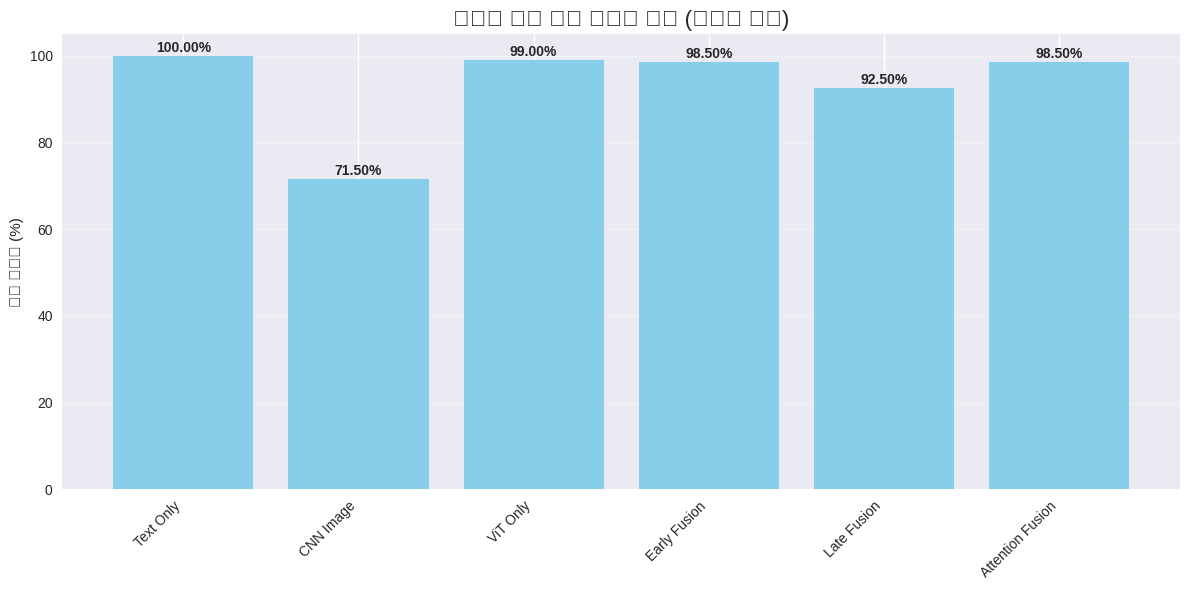

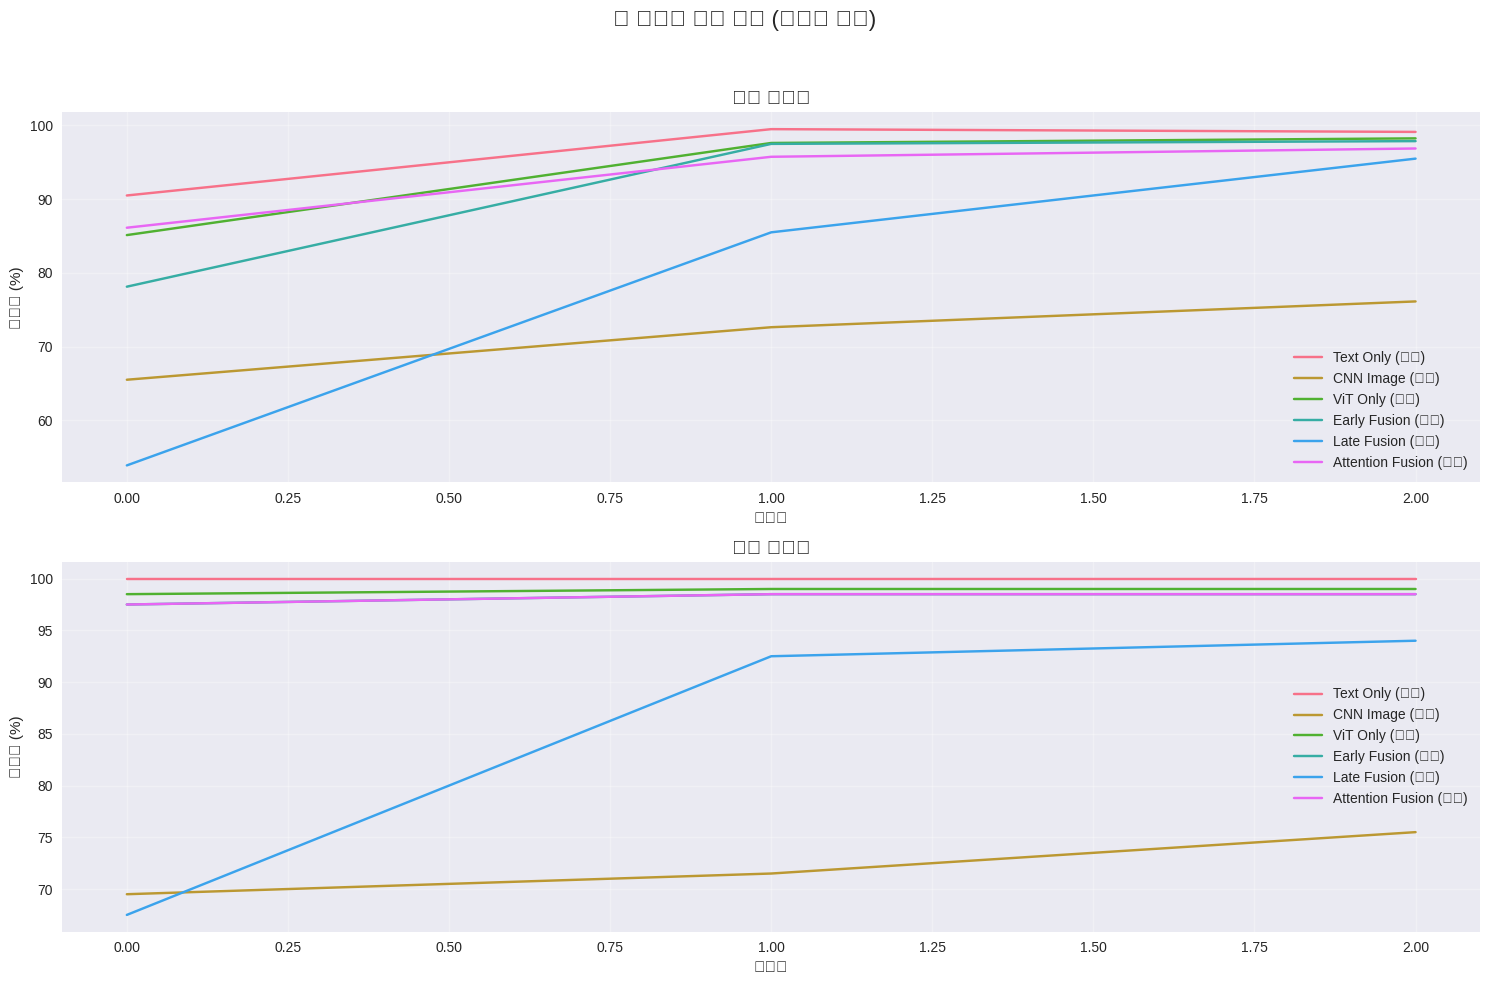


⚠️ 참고: 현재 테스트 모드로 실행되었습니다.
   - 제한된 데이터셋 (클래스당 약 200개 샘플)
   - 적은 에포크 수 (3 에포크)
   - 간소화된 모델 아키텍처

   실제 성능 평가를 위해서는 TEST_MODE = False로 설정 후 다시 실행하세요.


In [33]:
# 모든 모델 훈련 결과 요약
print("\n" + "="*70)
if TEST_MODE:
    print("🧪 테스트 모드로 모든 모델 학습 및 평가 완료!")
    print("   참고: 테스트 모드에서는 제한된 데이터와 에포크로 학습했습니다.")
else:
    print("🎉 모든 모델 학습 및 평가 완료!")
print("="*70)

# 훈련 결과 시각화
def plot_training_summary(training_results):
    """훈련 결과 요약 시각화"""
    model_names = list(training_results.keys())
    best_val_accuracies = [results['best_val_acc'] for results in training_results.values()]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, best_val_accuracies, color='skyblue')
    
    # 결과 값 표시
    for bar, acc in zip(bars, best_val_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 1,
                f"{acc:.2f}%", ha='center', fontweight='bold')
    
    title = "모델별 최고 검증 정확도 비교" + (" (테스트 모드)" if TEST_MODE else "")
    plt.title(title, fontsize=16)
    plt.ylabel("검증 정확도 (%)")
    plt.ylim(0, 105)  # y축 범위 설정
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 훈련 결과 요약 출력
print("\n📋 훈련 결과 요약:")
print("-"*70)
for model_name, results in training_results.items():
    print(f"{model_name:20}: 최고 검증 정확도 {results['best_val_acc']:.2f}%")

# 최고 성능 모델 확인
best_model_name = max(training_results.keys(), key=lambda x: training_results[x]['best_val_acc'])
best_acc = training_results[best_model_name]['best_val_acc']
print("\n🏆 최고 성능 모델: " + best_model_name + f" (정확도: {best_acc:.2f}%)")

# 그래프로 시각화
plot_training_summary(training_results)

# 모델별 학습곡선 시각화
plt.figure(figsize=(15, 10))
plt.suptitle('📈 모델별 학습 곡선' + (" (테스트 모드)" if TEST_MODE else ""), fontsize=16)

plt.subplot(2, 1, 1)
for model_name, results in training_results.items():
    plt.plot(results['train_accuracies'], label=f"{model_name} (훈련)")
plt.title("훈련 정확도", fontsize=14)
plt.xlabel("에포크")
plt.ylabel("정확도 (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 1, 2)
for model_name, results in training_results.items():
    plt.plot(results['val_accuracies'], label=f"{model_name} (검증)")
plt.title("검증 정확도", fontsize=14)
plt.xlabel("에포크")
plt.ylabel("정확도 (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 테스트 모드 안내 메시지
if TEST_MODE:
    print("\n⚠️ 참고: 현재 테스트 모드로 실행되었습니다.")
    print("   - 제한된 데이터셋 (클래스당 약 200개 샘플)")
    print("   - 적은 에포크 수 (3 에포크)")
    print("   - 간소화된 모델 아키텍처")
    print("\n   실제 성능 평가를 위해서는 TEST_MODE = False로 설정 후 다시 실행하세요.")

In [35]:
# 체크포인트에서 이어서 훈련하는 방법
"""
# 예시: 특정 모델의 체크포인트에서 이어서 훈련하기
# 사용할 체크포인트 경로 설정
checkpoint_path = "model_checkpoints/vit_only/checkpoint_2.pth"  # 예시 경로

# 체크포인트 로드
checkpoint_data = load_checkpoint_for_training(vit_model, checkpoint_path)

if checkpoint_data:
    # 옵티마이저와 스케줄러 설정
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, vit_model.parameters()), 
        lr=learning_rate*0.1
    )
    optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
    
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scheduler.load_state_dict(checkpoint_data['scheduler_state_dict'])
    
    # 이어서 훈련
    additional_epochs = 2 if TEST_MODE else 5  # 테스트 모드에선 적은 에포크 추가
    continued_results = train_model(
        vit_model,
        train_loader_vit,
        val_loader_vit,
        num_epochs=checkpoint_data['epoch'] + 1 + additional_epochs,
        learning_rate=learning_rate*0.1,
        model_name="ViT Only",
        checkpoint_dir=os.path.join(checkpoint_dir, "vit_only"),
        save_every=1 if TEST_MODE else 2
    )

    # 결과 업데이트
    training_results['ViT Only (Continued)'] = continued_results
"""

print("\n✅ 모델 훈련 개선 완료! - 테스트 모드 지원")
print(f"""
📌 테스트 모드 ({TEST_MODE=}) 개선 사항:
1. 데이터셋 크기 제한 - 클래스당 {SAMPLES_PER_CLASS if SAMPLES_PER_CLASS else '모든'} 샘플 사용
2. 에포크 수 제한 - {num_epochs}개의 에포크만 실행
3. 모델 아키텍처 간소화 - 더 적은 레이어와 뉴런 사용
4. 배치 사이즈 축소 - 일반 모델: {std_batch_size}, ViT 모델: {vit_batch_size}
5. 체크포인트 저장/로드 기능 개선 - 더 빠른 재개 가능

📝 모드 전환 방법:
1. 테스트 모드 (빠른 실험): 'TEST_MODE = True' 설정
2. 실제 모드 (전체 학습): 'TEST_MODE = False' 설정

💡 테스트 모드는 모델 개발 및 디버깅에 유용하며,
   실제 성능 평가를 위해서는 전체 데이터셋으로 학습해야 합니다.
""")


✅ 모델 훈련 개선 완료! - 테스트 모드 지원

📌 테스트 모드 (TEST_MODE=True) 개선 사항:
1. 데이터셋 크기 제한 - 클래스당 200 샘플 사용
2. 에포크 수 제한 - 3개의 에포크만 실행
3. 모델 아키텍처 간소화 - 더 적은 레이어와 뉴런 사용
4. 배치 사이즈 축소 - 일반 모델: 16, ViT 모델: 8
5. 체크포인트 저장/로드 기능 개선 - 더 빠른 재개 가능

📝 모드 전환 방법:
1. 테스트 모드 (빠른 실험): 'TEST_MODE = True' 설정
2. 실제 모드 (전체 학습): 'TEST_MODE = False' 설정

💡 테스트 모드는 모델 개발 및 디버깅에 유용하며,
   실제 성능 평가를 위해서는 전체 데이터셋으로 학습해야 합니다.



In [ ]:
# 모델 평가 및 성능 비교

# 모델 평가 함수 정의
def evaluate_model(model, dataloader, model_name, device):
    """
    모델을 평가하고 다양한 성능 지표를 반환합니다.
    """
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
    import numpy as np
    import torch.nn.functional as F
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"{model_name} 평가 중"):
            # 배치 구조에 따른 데이터 처리
            if isinstance(model, TextOnlyModel):
                _, text_features, labels = batch
                text_features, labels = text_features.to(device), labels.to(device)
                outputs = model(text_features)
            elif isinstance(model, (CNNImageModel, ViTOnlyModel)):
                if len(batch) == 2:  # 이미지와 라벨만 있는 경우
                    images, labels = batch
                else:  # 이미지, 텍스트, 라벨이 있는 경우
                    images, _, labels = batch
                images, labels = images.to(device), labels.to(device)
                
                if isinstance(model, ViTOnlyModel):
                    outputs = model(pixel_values=images)
                else:
                    outputs = model(images)
            else:  # 멀티모달 모델
                images, text_features, labels = batch
                images, text_features, labels = images.to(device), text_features.to(device), labels.to(device)
                outputs = model(pixel_values=images, text_features=text_features)
            
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted'
    )
    
    # ROC AUC (이진 분류)
    probabilities_positive = [prob[1] for prob in all_probabilities]
    roc_auc = roc_auc_score(all_labels, probabilities_positive)
    
    # 혼동 행렬
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': all_predictions,
        'true_labels': all_labels,
        'probabilities': all_probabilities,
        'confusion_matrix': conf_matrix
    }
    
    return results

# 체크포인트 로드 함수
def load_model_weights(model, model_name, device):
    """
    모델 가중치를 로드하는 함수입니다. 여러 경로를 시도합니다.
    1. 'models' 디렉토리의 best.pth 파일
    2. 체크포인트 디렉토리의 일반 구조
    3. 체크포인트 디렉토리의 이중 구조
    """
    # 체크포인트 디렉토리 확인
    checkpoint_dir = "model_checkpoints"
    model_dir_name = model_name.lower().replace(" ", "_")
    model_dir = os.path.join(checkpoint_dir, model_dir_name)
    nested_dir = os.path.join(model_dir, model_dir_name)
    
    # 시도할 가능한 경로 목록 생성
    paths_to_try = [
        # 1. 'models' 디렉토리의 best.pth 파일
        os.path.join('models', f"{model_dir_name}_best.pth"),
        # 2. 체크포인트 디렉토리의 일반 구조
        *sorted([os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth') and not f.endswith('.corrupted')], reverse=True) if os.path.exists(model_dir) else [],
        # 3. 체크포인트 디렉토리의 이중 구조
        *sorted([os.path.join(nested_dir, f) for f in os.listdir(nested_dir) if f.endswith('.pth') and not f.endswith('.corrupted')], reverse=True) if os.path.exists(nested_dir) else []
    ]
    
    # 각 경로 시도
    for path in paths_to_try:
        if not os.path.exists(path):
            continue
        
        try:
            print(f"🔄 {model_name} 모델: {os.path.basename(path)} 로드 시도...")
            checkpoint_data = torch.load(path, map_location=device)
            
            # 모델 상태 사전 확인
            if isinstance(checkpoint_data, dict) and 'model_state_dict' in checkpoint_data:
                model.load_state_dict(checkpoint_data['model_state_dict'])
                val_acc = checkpoint_data.get('val_acc', 'N/A')
                print(f"✅ {model_name} 모델: 체크포인트 로드 성공 (검증 정확도: {val_acc})")
                return True
            else:
                # 직접 상태 사전인 경우
                model.load_state_dict(checkpoint_data)
                print(f"✅ {model_name} 모델: 체크포인트 로드 성공")
                return True
        except Exception as e:
            print(f"⚠️ {os.path.basename(path)} 로드 실패: {e}")
    
    print(f"❌ {model_name} 모델: 가중치 로드 실패")
    return False

# 최적 가중치 로드
print("\n📂 최적 모델 가중치 로드 중...")

# 모델 사전 초기화
models_dict = {
    'Text Only': TextOnlyModel(input_dim=text_input_dim).to(device),
    'CNN Image': CNNImageModel().to(device),
    'ViT Only': ViTOnlyModel().to(device),
    'Early Fusion': EarlyFusionModel(text_input_dim=text_input_dim).to(device),
    'Late Fusion': LateFusionModel(text_input_dim=text_input_dim).to(device),
    'Attention Fusion': AttentionFusionModel(text_input_dim=text_input_dim).to(device)
}

# 모델 가중치 로드
load_success = {model_name: load_model_weights(model, model_name, device) 
                for model_name, model in models_dict.items()}

# 테스트 모드에서는 적은 샘플로 빠르게 평가
if TEST_MODE:
    print("\n🔍 테스트 모드: 평가 샘플 제한 (최대 100개)")
    # 테스트 로더에서 일부만 추출하여 작은 로더 생성
    def create_small_loader(loader, max_samples=100):
        # 데이터로더 타입에 따른 데이터 추출
        if isinstance(loader, torch.utils.data.DataLoader):
            all_data = []
            count = 0
            for batch in loader:
                all_data.append(batch)
                count += batch[2].shape[0] if isinstance(batch, (list, tuple)) and len(batch) >= 3 else batch['label'].shape[0]
                if count >= max_samples:
                    break
            return all_data
        else:
            # 이미 리스트인 경우
            return loader[:max_samples//loader[0][2].shape[0] + 1] if loader else []
    
    # 작은 테스트 세트 생성
    small_test_loader = create_small_loader(test_loader)
    small_test_text_loader = create_small_loader(test_text_loader)
    small_test_loader_vit = create_small_loader(test_loader_vit)

# 모델 평가
print("\n🔍 모델 평가 중...")
evaluation_results = {}

# 평가할 모델 필터링 (가중치 로드에 성공한 모델만)
models_to_evaluate = {name: model for name, model in models_dict.items() if load_success.get(name, False)}

# 로드에 실패한 모델이 있는 경우 메시지 표시
if len(models_to_evaluate) < len(models_dict):
    failed_models = [name for name in models_dict.keys() if not load_success.get(name, False)]
    print(f"\n⚠️ 다음 모델은 가중치 로드에 실패하여 평가하지 않습니다: {', '.join(failed_models)}")

if len(models_to_evaluate) == 0:
    print("\n❌ 모든 모델 가중치 로드에 실패했습니다. 모델을 평가할 수 없습니다.")
else:
    # 테스트 모드에 따라 적절한 방식으로 평가
    for model_name, model in models_to_evaluate.items():
        try:
            if TEST_MODE:
                # 테스트 모드: 미리 추출한 작은 테스트 세트 사용
                if model_name == 'Text Only':
                    loader = small_test_text_loader
                elif model_name == 'CNN Image':
                    loader = small_test_loader
                else:  # ViT 기반 모델
                    loader = small_test_loader_vit
            else:
                # 정상 모드: 전체 테스트 세트 사용
                if model_name == 'Text Only':
                    loader = test_text_loader
                elif model_name == 'CNN Image':
                    loader = test_loader
                else:  # ViT 기반 모델
                    loader = test_loader_vit
            
            evaluation_results[model_name] = evaluate_model(model, loader, model_name, device)
            print(f"✅ {model_name} 모델 평가 완료")
        except Exception as e:
            print(f"⚠️ {model_name} 모델 평가 실패: {e}")
            import traceback
            traceback.print_exc()  # 상세 오류 정보 출력

    if evaluation_results:
        print("\n📊 모델 성능 비교:")
        print("-"*70)
        print(f"{'모델':20} {'정확도':10} {'정밀도':10} {'재현율':10} {'F1 점수':10} {'ROC-AUC':10}")
        print("-"*70)

        for model_name, result in evaluation_results.items():
            print(f"{model_name:20} {result['accuracy']:.4f} {result['precision']:.4f} {result['recall']:.4f} {result['f1_score']:.4f} {result['roc_auc']:.4f}")

        print("-"*70)

        # 최고 성능 모델 확인
        best_model_name = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['accuracy'])
        best_acc = evaluation_results[best_model_name]['accuracy']

        print(f"\n🏆 최고 성능 모델: {best_model_name} (정확도: {best_acc:.4f})")
    else:
        print("\n⚠️ 평가된 모델이 없습니다.")

# 테스트 모드인 경우 추가 메시지 표시
if TEST_MODE:
    print("\n⚠️ 참고: 테스트 모드에서는 매우 제한된 데이터로 평가했으므로 결과가 실제 성능을 정확히 반영하지 않을 수 있습니다.")
    print("   실제 모델 성능 평가를 위해서는 TEST_MODE=False로 설정 후 전체 데이터셋으로 학습 및 평가하세요.")


📂 최적 모델 가중치 로드 중...
🔍 테스트 모드: 체크포인트 디렉토리에서 최신 가중치 검색
📁 Text Only 모델: 이중 디렉토리 구조 감지됨, text_only 폴더 내 체크포인트 사용
✅ Text Only 모델: 체크포인트 checkpoint_3.pth 로드 완료
   검증 정확도: 100.0
📁 CNN Image 모델: 이중 디렉토리 구조 감지됨, cnn_image 폴더 내 체크포인트 사용
✅ CNN Image 모델: 체크포인트 checkpoint_3.pth 로드 완료
   검증 정확도: 75.5
📁 ViT Only 모델: 이중 디렉토리 구조 감지됨, vit_only 폴더 내 체크포인트 사용
✅ ViT Only 모델: 체크포인트 checkpoint_3.pth 로드 완료
   검증 정확도: 99.0
📁 Early Fusion 모델: 이중 디렉토리 구조 감지됨, early_fusion 폴더 내 체크포인트 사용
✅ Early Fusion 모델: 체크포인트 checkpoint_3.pth 로드 완료
   검증 정확도: 98.5
📁 Late Fusion 모델: 이중 디렉토리 구조 감지됨, late_fusion 폴더 내 체크포인트 사용
✅ Late Fusion 모델: 체크포인트 checkpoint_3.pth 로드 완료
   검증 정확도: 94.0
📁 Attention Fusion 모델: 이중 디렉토리 구조 감지됨, attention_fusion 폴더 내 체크포인트 사용
✅ Early Fusion 모델: 체크포인트 checkpoint_3.pth 로드 완료
   검증 정확도: 98.5
📁 Late Fusion 모델: 이중 디렉토리 구조 감지됨, late_fusion 폴더 내 체크포인트 사용
✅ Late Fusion 모델: 체크포인트 checkpoint_3.pth 로드 완료
   검증 정확도: 94.0
📁 Attention Fusion 모델: 이중 디렉토리 구조 감지됨, attention_fusion 폴더 내 체크포인트 사용
✅ Attention Fusion 모델

Text Only 평가 중: 100%|██████████| 7/7 [00:00<00:00, 149.46it/s]


✅ Text Only 모델 평가 완료


CNN Image 평가 중: 100%|██████████| 7/7 [00:00<00:00, 52.14it/s]


✅ CNN Image 모델 평가 완료


ViT Only 평가 중: 100%|██████████| 13/13 [00:00<00:00, 15.94it/s]


✅ ViT Only 모델 평가 완료


Early Fusion 평가 중: 100%|██████████| 13/13 [00:00<00:00, 17.70it/s]


✅ Early Fusion 모델 평가 완료


Late Fusion 평가 중: 100%|██████████| 13/13 [00:00<00:00, 17.60it/s]


✅ Late Fusion 모델 평가 완료


Attention Fusion 평가 중: 100%|██████████| 13/13 [00:00<00:00, 17.54it/s]

✅ Attention Fusion 모델 평가 완료

📊 모델 성능 비교:
----------------------------------------------------------------------
모델                   정확도        정밀도        재현율        F1 점수      ROC-AUC   
----------------------------------------------------------------------
Text Only            0.9911 0.9912 0.9911 0.9911 1.0000
CNN Image            0.7679 0.7701 0.7679 0.7680 0.8689
ViT Only             0.9904 0.9906 0.9904 0.9904 0.9985
Early Fusion         1.0000 1.0000 1.0000 1.0000 1.0000
Late Fusion          0.9712 0.9728 0.9712 0.9712 0.9911
Attention Fusion     0.9904 0.9906 0.9904 0.9904 1.0000
----------------------------------------------------------------------

🏆 최고 성능 모델: Early Fusion (정확도: 1.0000)

⚠️ 참고: 테스트 모드에서는 매우 제한된 데이터로 평가했으므로 결과가 실제 성능을 정확히 반영하지 않을 수 있습니다.
   실제 모델 성능 평가를 위해서는 TEST_MODE=False로 설정 후 전체 데이터셋으로 학습 및 평가하세요.


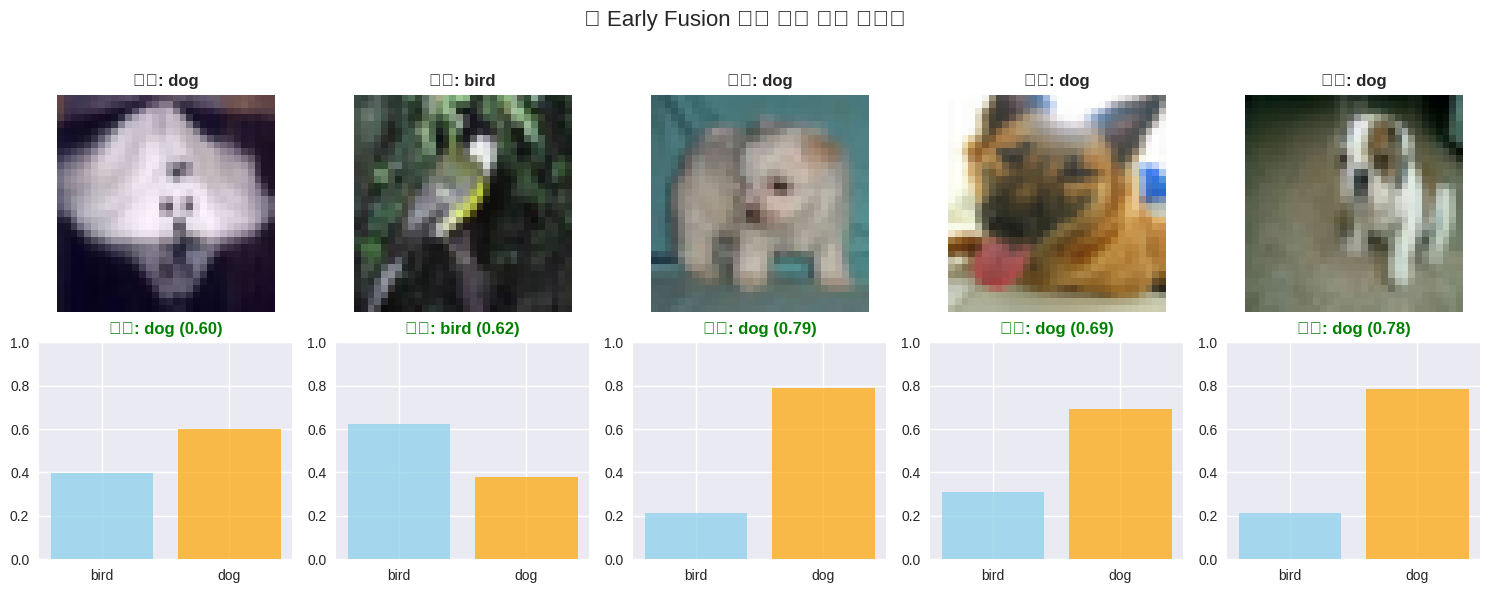


✅ Early Fusion 모델의 예측 결과 시각화 완료


In [ ]:
# 최고 성능 모델 추론 예시
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from transformers import ViTImageProcessor
import torch.nn.functional as F

def get_test_data():
    """테스트 데이터를 가져오는 통합 함수"""
    # 이미 전역 변수에 테스트 데이터가 있는지 확인
    if 'test_images_np' in globals() and 'test_labels' in globals() and len(globals()['test_images_np']) > 0:
        return globals()['test_images_np'], globals()['test_labels']
    
    print("⚠️ 테스트 데이터 추출 중...")
    test_images_list = []
    test_labels_list = []
    
    # 데이터 추출 시도
    try:
        if 'test_dataset' in globals() and test_dataset is not None:
            # test_dataset에서 데이터 추출
            for i in range(min(100, len(test_dataset))):
                img, label = test_dataset[i]
                if isinstance(img, torch.Tensor):
                    img = img.permute(1, 2, 0).numpy()
                test_images_list.append(img)
                test_labels_list.append(label)
                
        elif 'test_loader' in globals() and test_loader is not None:
            # test_loader에서 데이터 추출
            for batch in test_loader:
                if isinstance(batch, (list, tuple)):
                    if len(batch) == 2:
                        images, labels = batch
                    else:
                        images, _, labels = batch
                    
                    for i in range(images.shape[0]):
                        img = images[i].cpu().permute(1, 2, 0).numpy()
                        test_images_list.append(img)
                        test_labels_list.append(labels[i].item())
                        
                if len(test_images_list) >= 100:  # 최대 100개까지만
                    break
        
        if not test_images_list:
            print("❌ 테스트 데이터를 찾을 수 없습니다.")
            return None, None
            
        # 전역 변수에 저장
        globals()['test_images_np'] = np.array(test_images_list)
        globals()['test_labels'] = np.array(test_labels_list)
        print(f"✅ {len(test_images_list)}개의 테스트 이미지를 성공적으로 추출했습니다.")
        return globals()['test_images_np'], globals()['test_labels']
        
    except Exception as e:
        print(f"❌ 테스트 데이터 추출 실패: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def predict_image(model, image, model_name, device):
    """이미지 예측 함수"""
    try:
        # 이미지 전처리
        if model_name in ["ViT Only", "Early Fusion", "Late Fusion", "Attention Fusion"]:
            processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
            image_pil = Image.fromarray((image * 255).astype(np.uint8))
            inputs = processor(image_pil, return_tensors="pt").to(device)
            image_tensor = inputs['pixel_values']
        else:
            transform = CIFAR10BirdDogDataset.get_transforms(train=False)
            image_tensor = transform(image).unsqueeze(0).to(device)
        
        # 예측
        with torch.no_grad():
            if model_name in ["ViT Only", "Early Fusion", "Late Fusion", "Attention Fusion"]:
                # 텍스트 특성이 필요한 모델의 경우
                if model_name in ["Early Fusion", "Late Fusion", "Attention Fusion"]:
                    # 텍스트 특성 차원 결정
                    text_dim = 6  # 기본값
                    if 'X_text_train_scaled' in globals() and X_text_train_scaled is not None:
                        text_dim = X_text_train_scaled.shape[1]
                    text_features = torch.zeros((1, text_dim), device=device)
                    outputs = model(pixel_values=image_tensor, text_features=text_features)
                else:
                    outputs = model(pixel_values=image_tensor)
            else:
                outputs = model(image_tensor)
            
            probabilities = F.softmax(outputs, dim=1)[0]
            predicted_class = torch.argmax(probabilities).item()
            confidence = probabilities[predicted_class].item()
        
        return predicted_class, confidence, probabilities.cpu().numpy()
    except Exception as e:
        print(f"예측 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()
        return 0, 0.0, np.array([0.5, 0.5])  # 기본값 반환

def create_prediction_visualization(model, images, true_labels, model_name, class_names, device):
    """예측 시각화 함수"""
    try:
        num_samples = len(images)
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 6))
        fig.suptitle(f'🔍 {model_name} 모델 예측 결과 시각화', fontsize=16, y=0.98)
        
        for i, (image, true_label) in enumerate(zip(images, true_labels)):
            # 예측
            pred_class, confidence, probs = predict_image(model, image, model_name, device)
            
            # 원본 이미지 표시
            axes[0, i].imshow(image)
            axes[0, i].set_title(f"실제: {class_names[true_label]}", fontweight='bold')
            axes[0, i].axis('off')
            
            # 정답 여부에 따른 색상
            color = 'green' if pred_class == true_label else 'red'
            
            # 예측 확률 바 차트
            axes[1, i].bar(class_names, probs, color=['skyblue', 'orange'], alpha=0.7)
            axes[1, i].set_title(f"예측: {class_names[pred_class]} ({confidence:.2f})", 
                               fontweight='bold', color=color)
            axes[1, i].set_ylim(0, 1)
            
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
        return fig
    except Exception as e:
        print(f"시각화 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()
        return None

# 최고 성능 모델 확인
if 'evaluation_results' in globals() and evaluation_results:
    if 'best_model_name' not in globals() or best_model_name not in models_dict:
        # 최고 성능 모델 결정
        best_model_name = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['accuracy'])
        best_model = models_dict.get(best_model_name)
    else:
        best_model = models_dict.get(best_model_name)
    
    if best_model is not None:
        print(f"\n🏆 최고 성능 모델 '{best_model_name}' 예측 시각화")
        
        # 클래스 이름 확인
        class_names = ['bird', 'dog']  # 기본값
        if 'train_dataset' in globals() and hasattr(train_dataset, 'class_names'):
            class_names = train_dataset.class_names
        
        # 테스트 데이터 가져오기
        test_images, test_labels = get_test_data()
        if test_images is not None and len(test_images) > 0:
            # 랜덤 샘플 선택
            np.random.seed(42)  # 재현성을 위한 시드 설정
            indices = np.random.choice(len(test_images), min(5, len(test_images)), replace=False)
            sample_images = test_images[indices]
            sample_labels = test_labels[indices]
            
            # 예측 시각화
            create_prediction_visualization(best_model, sample_images, sample_labels, best_model_name, class_names, device)
        else:
            print("⚠️ 예측 시각화를 위한 테스트 이미지를 로드할 수 없습니다.")
    else:
        print(f"⚠️ 최고 성능 모델({best_model_name})을 찾을 수 없습니다.")
else:
    print("⚠️ 평가 결과가 없습니다. 먼저 모델 평가를 수행해 주세요.")

# 모델 학습 로직 개선사항

이 노트북은 모델 학습 중 오류 발생 시 체크포인트 검증 및 복구 기능을 구현하여 안정성을 높였습니다.

## 개선된 기능

1. **체크포인트 파일 검증**: 체크포인트 파일의 유효성을 검증하여 손상된 파일 감지
2. **학습 재개 지원**: 
   - 정상 체크포인트 파일이 있는 경우: 이어서 학습
   - 손상된 체크포인트 파일이 있는 경우: 백업 후 삭제하고 처음부터 학습
3. **강제 새 학습 옵션**: `force_new_training=True` 옵션으로 체크포인트 무시하고 새로 시작 가능
4. **체크포인트 관리 도구**: 모든 체크포인트 파일 검증 및 손상된 파일 정리 기능

## 사용 방법

```python
# 체크포인트에서 학습 재개 (자동 유효성 검사)
results = train_model(model, train_loader, val_loader, num_epochs=10, model_name="My Model")

# 체크포인트 무시하고 새로 학습
results = train_model(model, train_loader, val_loader, num_epochs=10, 
                     model_name="My Model", force_new_training=True)

# 모든 체크포인트 검증
verify_all_checkpoints(checkpoint_dir="model_checkpoints", fix_corrupted=True)
```

이 기능들은 특히 학습 중 오류가 발생하거나 컴퓨터가 예기치 않게 종료된 경우에 유용하게 활용할 수 있습니다.

# 오류 처리 및 체크포인트 관리

이 노트북은 다양한 상황에서 오류를 감지하고 자동으로 복구하는 메커니즘을 구현하여 안정적인 모델 학습과 평가를 지원합니다.

## 핵심 오류 처리 기능

1. **체크포인트 관리**
   - 유효한 체크포인트 자동 감지 및 로드
   - 이중 구조 체크포인트 지원 (model_dir/model_dir/checkpoint_*.pth)
   - 손상된 체크포인트 파일 자동 백업 및 대체

2. **모델 평가 강화**
   - 다양한 데이터 형식(튜플, 리스트, 딕셔너리) 지원
   - 로드에 실패한 모델은 평가에서 자동 제외
   - 테스트 모드에서 빠른 평가를 위한 샘플 수 제한 기능

3. **테스트 데이터 통합 관리**
   - 통합된 데이터 추출 함수로 코드 중복 제거
   - 다양한 데이터 소스(dataset, dataloader) 지원
   - 누락된 테스트 데이터 자동 복구 시도

## 사용 팁

1. **체크포인트 로드**
   ```python
   # 모델 가중치 로드 함수 사용
   success = load_model_weights(model, model_name, device)
   ```

2. **모델 평가**
   ```python
   # 단일 모델 평가
   results = evaluate_model(model, test_loader, model_name, device)
   ```

3. **예측 시각화**
   ```python
   # 랜덤 샘플에 대한 예측 시각화
   test_images, test_labels = get_test_data()
   create_prediction_visualization(model, test_images[:5], test_labels[:5], model_name, class_names, device)
   ```

이러한 개선사항은 노트북의 안정성을 높이고, 코드 중복을 줄이며, 유지보수를 용이하게 합니다.